# Imports 

In [1]:
import os
import json
import pandas as pd
import json
from round_analysis import RoundAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 

/Users/christophhau/Desktop/HA_Projekt/MIMIC/MIMIC/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Inspect Results 

In [4]:


def count_experiment_stats(users_dict_path, target_run_id=None):
    """
    Counts basic stats for a given run_id across all user files.
    
    :param users_dict_path: Path to directory containing user .jsonl files
    :param target_run_id: Optional run_id to analyze. If None, uses latest from first file
    :return: Dictionary with counts and statistics
    """
    
    # Find all jsonl files
    user_files = [f for f in os.listdir(users_dict_path) if f.endswith('.jsonl')]
    if not user_files:
        print(f"No .jsonl files found in {users_dict_path}")
        return None
    
    total_files = len(user_files)
    files_with_run_data = 0
    
    # Get run_id if not provided
    if target_run_id is None:
        for uf in user_files:
            try:
                with open(os.path.join(users_dict_path, uf), 'r', encoding='utf-8') as f:
                    lines = f.readlines()
                    if len(lines) > 2:
                        runs_data = json.loads(lines[2].strip())
                        if runs_data.get('runs'):
                            target_run_id = runs_data['runs'][-1]['run_id']
                            print(f"Using run_id from {uf}: {target_run_id}")
                            break
            except (json.JSONDecodeError, IndexError, FileNotFoundError):
                continue
    
    if not target_run_id:
        print("Could not determine run_id")
        return None
    
    # Count stats
    user_stats = {}
    
    for user_file in user_files:
        user_file_path = os.path.join(users_dict_path, user_file)
        user_id = os.path.splitext(user_file)[0]
        
        try:
            with open(user_file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
            
            # Get actual user_id from file if available
            if len(lines) > 0:
                user_info = json.loads(lines[0].strip())
                if 'user_id' in user_info:
                    user_id = user_info['user_id']
            
            # Check if this file has run data for our target run
            has_run_data = False
            imitation_count = 0
            
            if len(lines) > 2:
                try:
                    runs_content = json.loads(lines[2].strip())
                    target_run = next((r for r in runs_content.get('runs', []) 
                                     if r.get('run_id') == target_run_id), None)
                    if target_run:
                        has_run_data = True
                        imitation_count = len(target_run.get('imitations', []))
                except json.JSONDecodeError:
                    pass
            
            if has_run_data:
                files_with_run_data += 1
                
                # Count rounds (evaluations)
                round_count = 0
                if len(lines) > 3:
                    try:
                        eval_content = json.loads(lines[3].strip())
                        round_count = len([e for e in eval_content.get('evaluations', []) 
                                         if e.get('run_id') == target_run_id])
                    except json.JSONDecodeError:
                        pass
                
                user_stats[user_id] = {
                    'rounds': round_count,
                    'imitations': imitation_count
                }
        
        except Exception as e:
            print(f"Error processing {user_file}: {e}")
            continue
    
    # Summary
    results = {
        'run_id': target_run_id,
        'total_files_checked': total_files,
        'files_with_run_data': files_with_run_data,
        'total_users_in_run': len(user_stats),
        'user_stats': user_stats
    }
    
    return results

def print_summary(results):
    """Print a nice summary of the results"""
    if not results:
        print("No results to display")
        return
    
    print(f"\n=== EXPERIMENT SUMMARY ===")
    print(f"Run ID: {results['run_id']}")
    print(f"Files checked: {results['total_files_checked']}")
    print(f"Files with run data: {results['files_with_run_data']}")
    print(f"Users in this run: {results['total_users_in_run']}")
    
    if results['user_stats']:
        print(f"\nPer-user breakdown:")
        for user_id, stats in results['user_stats'].items():
            print(f"  {user_id}: {stats['rounds']} rounds, {stats['imitations']} imitations")
        
        # Quick stats
        rounds_list = [stats['rounds'] for stats in results['user_stats'].values()]
        imitations_list = [stats['imitations'] for stats in results['user_stats'].values()]
        
        print(f"\nQuick stats:")
        print(f"  Total rounds across all users: {sum(rounds_list)}")
        print(f"  Total imitations across all users: {sum(imitations_list)}")
        if rounds_list:
            print(f"  Average rounds per user: {sum(rounds_list)/len(rounds_list):.1f}")
        if imitations_list:
            print(f"  Average imitations per user: {sum(imitations_list)/len(imitations_list):.1f}")

# Usage example:
if __name__ == "__main__":
    # Replace with your actual path
    path = "data/filtered_users"
    
    # Count stats for latest run (or specify run_id)
    results = count_experiment_stats(path, '2025_07_09_1446')
    
    if results:
        print_summary(results)


=== EXPERIMENT SUMMARY ===
Run ID: 2025_07_09_1446
Files checked: 127
Files with run data: 0
Users in this run: 0


# Round Perfomance 


In [5]:
# Create analyzer instance
analyzer = RoundAnalyzer(users_directory="data/filtered_users")

# Get the raw data
df = analyzer.analyze_all_users()

# Function to extract metrics from nested data
def extract_metrics(df):
    """Extract evaluation metrics from nested data structure"""
    extracted_rows = []
    
    for _, row in df.iterrows():
        base_row = {
            'user_id': row['user_id'],
            'round': row['round'],
            'run_id': row['run_id'],
            'timestamp': row['timestamp']
        }
        
        # Extract from statistics dictionary
        if isinstance(row['statistics'], dict):
            stats = row['statistics']
            base_row['mean_combined_score'] = stats.get('mean_combined_score', 0)
            base_row['std_combined_score'] = stats.get('std_combined_score', 0)
            base_row['best_score'] = stats.get('best_score', 0)
            base_row['worst_score'] = stats.get('worst_score', 0)
        
        # Extract from overall dictionary/value
        if isinstance(row['overall'], dict):
            overall = row['overall']
            base_row['overall_score'] = overall.get('score', 0)
        elif isinstance(row['overall'], (int, float)):
            base_row['overall_score'] = row['overall']
        
        # Extract individual scores statistics
        if isinstance(row['individual_scores'], list):
            scores = []
            rouge_scores = []
            bleu_scores = []
            combined_scores = []
            
            for item in row['individual_scores']:
                if isinstance(item, dict):
                    # Extract combined score
                    if 'combined_score' in item:
                        combined_scores.append(item['combined_score'])
                    
                    # Extract ROUGE scores
                    if 'rouge' in item and isinstance(item['rouge'], dict):
                        rouge_scores.append(item['rouge'].get('rouge1', 0))
                    
                    # Extract BLEU scores
                    if 'bleu' in item and isinstance(item['bleu'], dict):
                        bleu_scores.append(item['bleu'].get('bleu', 0))
            
            # Calculate aggregated metrics
            if combined_scores:
                base_row['individual_mean_combined'] = sum(combined_scores) / len(combined_scores)
                base_row['individual_max_combined'] = max(combined_scores)
                base_row['individual_min_combined'] = min(combined_scores)
            
            if rouge_scores:
                base_row['individual_mean_rouge1'] = sum(rouge_scores) / len(rouge_scores)
                base_row['individual_max_rouge1'] = max(rouge_scores)
            
            if bleu_scores:
                base_row['individual_mean_bleu'] = sum(bleu_scores) / len(bleu_scores)
                base_row['individual_max_bleu'] = max(bleu_scores)
        
        extracted_rows.append(base_row)
    
    return pd.DataFrame(extracted_rows)

# Extract metrics
df_metrics = extract_metrics(df)

print("Extracted metrics columns:")
print(df_metrics.columns.tolist())
print("\nFirst few rows:")
print(df_metrics.head())

# Get numeric columns for analysis
numeric_cols = df_metrics.select_dtypes(include=['number']).columns
metric_cols = [col for col in numeric_cols if col != 'round']
print(f"\nMetric columns: {metric_cols}")


Extracted metrics columns:
['user_id', 'round', 'run_id', 'timestamp', 'mean_combined_score', 'std_combined_score', 'best_score', 'worst_score', 'overall_score', 'individual_mean_combined', 'individual_max_combined', 'individual_min_combined', 'individual_mean_rouge1', 'individual_max_rouge1', 'individual_mean_bleu', 'individual_max_bleu']

First few rows:
                  user_id  round                   run_id  \
0  1.1782932009073132e+18      1  2025_07_16_mac2_round_1   
1  1.1782932009073132e+18      2  2025_07_16_mac2_round_2   
2  1.1782932009073132e+18      3  2025_07_16_mac2_round_3   
3  1.1782932009073132e+18      4  2025_07_16_mac2_round_4   
4  1.1782932009073132e+18      5  2025_07_16_mac2_round_5   

                    timestamp  mean_combined_score  std_combined_score  \
0  2025-07-16T16:54:45.815493             0.273449            0.304767   
1  2025-07-16T17:00:42.060918             0.246463            0.275804   
2  2025-07-16T17:04:18.759631             0.230255  

In [6]:
# Calculate aggregated statistics by round
def get_round_statistics(df_metrics):
    """Get aggregated statistics by round"""
    if df_metrics.empty:
        return pd.DataFrame()
    
    numeric_cols = df_metrics.select_dtypes(include=['number']).columns
    metric_cols = [col for col in numeric_cols if col != 'round']
    
    if not metric_cols:
        return pd.DataFrame()
    
    # Group by round and calculate statistics
    aggregated = df_metrics.groupby('round')[metric_cols].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    
    # Flatten column names
    aggregated.columns = [f"{metric}_{stat}" for metric, stat in aggregated.columns]
    
    return aggregated.reset_index()

# Get aggregated results
aggregated_results = get_round_statistics(df_metrics)
print("\nAggregated Results by Round:")
print(aggregated_results)



Aggregated Results by Round:
    round  mean_combined_score_mean  mean_combined_score_std  \
0       1                    0.1972                   0.0709   
1       2                    0.2199                   0.0811   
2       3                    0.2341                   0.0916   
3       4                    0.2439                   0.1017   
4       5                    0.2595                   0.1088   
5       6                    0.2581                   0.1131   
6       7                    0.2657                   0.1094   
7       8                    0.2702                   0.1027   
8       9                    0.2722                   0.1080   
9      10                    0.2773                   0.1126   
10     11                    0.2829                   0.1138   
11     12                    0.2660                   0.1151   
12     13                    0.2805                   0.1135   
13     14                    0.2783                   0.1113   
14     15 

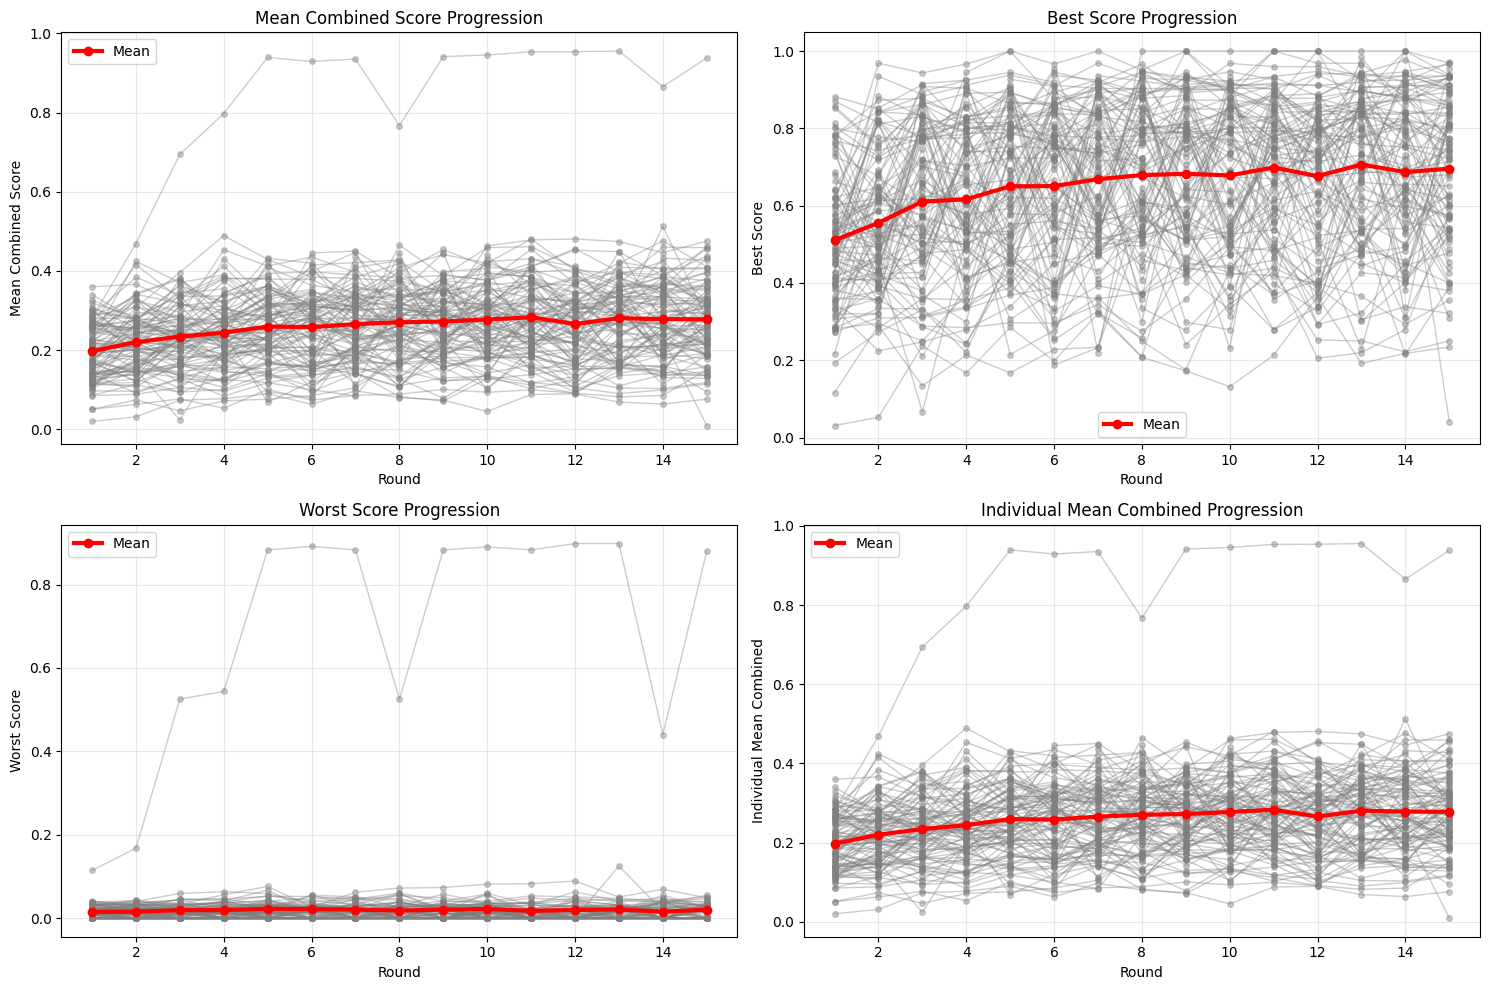

In [7]:
# Create progression plots
def plot_metric_progression(df_metrics, metrics=None):
    """Plot progression of metrics across rounds"""
    if df_metrics.empty:
        print("No data to plot")
        return
    
    # Default metrics to plot
    if metrics is None:
        metrics = ['mean_combined_score', 'best_score', 'worst_score', 'individual_mean_combined']
        # Filter to only existing columns
        metrics = [m for m in metrics if m in df_metrics.columns]
    
    if not metrics:
        print("No metrics available to plot")
        return
    
    # Create subplots
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Individual user lines (light)
        for user_id in df_metrics['user_id'].unique():
            user_data = df_metrics[df_metrics['user_id'] == user_id].sort_values('round')
            if len(user_data) > 1:
                ax.plot(user_data['round'], user_data[metric], 
                       alpha=0.4, color='gray', linewidth=1, marker='o', markersize=4)
        
        # Aggregated mean line (bold)
        round_means = df_metrics.groupby('round')[metric].mean()
        ax.plot(round_means.index, round_means.values, 
               color='red', linewidth=3, marker='o', markersize=6, label='Mean')
        
        ax.set_title(f'{metric.replace("_", " ").title()} Progression')
        ax.set_xlabel('Round')
        ax.set_ylabel(metric.replace("_", " ").title())
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Remove empty subplots
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Plot progression
plot_metric_progression(df_metrics)


# ANALYZE II

In [ ]:
def extract_metrics(df):
    """Extract evaluation metrics from nested data structure"""
    extracted_rows = []
    
    print(f"Processing {len(df)} rows...")
    
    for idx, row in df.iterrows():
        try:
            # Basic row info - these columns exist and are directly accessible
            base_row = {
                'user_id': row['user_id'],
                'round': row['round'],
                'run_id': row['run_id'],
                'timestamp': row['timestamp']
            }
            
            # Extract from statistics dictionary (this exists and has the right structure)
            if isinstance(row['statistics'], dict):
                stats_dict = row['statistics']
                base_row['mean_combined_score'] = stats_dict.get('mean_combined_score', 0)
                base_row['std_combined_score'] = stats_dict.get('std_combined_score', 0)
                base_row['best_score'] = stats_dict.get('best_score', 0)
                base_row['worst_score'] = stats_dict.get('worst_score', 0)
            
            # Extract from overall dictionary
            if isinstance(row['overall'], dict):
                overall_dict = row['overall']
                
                # Extract ROUGE scores from overall
                if 'rouge' in overall_dict and isinstance(overall_dict['rouge'], dict):
                    rouge = overall_dict['rouge']
                    base_row['overall_rouge1'] = rouge.get('rouge1', 0)
                    base_row['overall_rouge2'] = rouge.get('rouge2', 0)
                    base_row['overall_rougeL'] = rouge.get('rougeL', 0)
                    base_row['overall_rougeLsum'] = rouge.get('rougeLsum', 0)
                
                # Extract BLEU scores from overall
                if 'bleu' in overall_dict and isinstance(overall_dict['bleu'], dict):
                    bleu = overall_dict['bleu']
                    base_row['overall_bleu'] = bleu.get('bleu', 0)
                    if 'precisions' in bleu and isinstance(bleu['precisions'], list):
                        precisions = bleu['precisions']
                        base_row['overall_bleu_p1'] = precisions[0] if len(precisions) > 0 else 0
                        base_row['overall_bleu_p2'] = precisions[1] if len(precisions) > 1 else 0
                        base_row['overall_bleu_p3'] = precisions[2] if len(precisions) > 2 else 0
                        base_row['overall_bleu_p4'] = precisions[3] if len(precisions) > 3 else 0
                
                # Extract total samples
                base_row['total_samples'] = overall_dict.get('total_samples', 0)
            
            # Extract individual scores statistics
            if isinstance(row['individual_scores'], list):
                individual_scores = row['individual_scores']
                
                # Extract all combined scores
                combined_scores = []
                rouge1_scores = []
                rouge2_scores = []
                rougeL_scores = []
                bleu_scores = []
                
                for item in individual_scores:
                    if isinstance(item, dict):
                        # Combined score
                        if 'combined_score' in item:
                            combined_scores.append(item['combined_score'])
                        
                        # ROUGE scores
                        if 'rouge' in item and isinstance(item['rouge'], dict):
                            rouge = item['rouge']
                            rouge1_scores.append(rouge.get('rouge1', 0))
                            rouge2_scores.append(rouge.get('rouge2', 0))
                            rougeL_scores.append(rouge.get('rougeL', 0))
                        
                        # BLEU scores
                        if 'bleu' in item and isinstance(item['bleu'], dict):
                            bleu_scores.append(item['bleu'].get('bleu', 0))
                
                # Calculate statistics for individual scores
                if combined_scores:
                    base_row['individual_mean_combined'] = np.mean(combined_scores)
                    base_row['individual_std_combined'] = np.std(combined_scores)
                    base_row['individual_max_combined'] = np.max(combined_scores)
                    base_row['individual_min_combined'] = np.min(combined_scores)
                    base_row['individual_median_combined'] = np.median(combined_scores)
                
                if rouge1_scores:
                    base_row['individual_mean_rouge1'] = np.mean(rouge1_scores)
                    base_row['individual_max_rouge1'] = np.max(rouge1_scores)
                    base_row['individual_min_rouge1'] = np.min(rouge1_scores)
                
                if rouge2_scores:
                    base_row['individual_mean_rouge2'] = np.mean(rouge2_scores)
                    base_row['individual_max_rouge2'] = np.max(rouge2_scores)
                
                if rougeL_scores:
                    base_row['individual_mean_rougeL'] = np.mean(rougeL_scores)
                    base_row['individual_max_rougeL'] = np.max(rougeL_scores)
                
                if bleu_scores:
                    base_row['individual_mean_bleu'] = np.mean(bleu_scores)
                    base_row['individual_max_bleu'] = np.max(bleu_scores)
                    base_row['individual_min_bleu'] = np.min(bleu_scores)
                
                # Count of samples
                base_row['num_individual_scores'] = len(individual_scores)
            
            extracted_rows.append(base_row)
            
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue
    
    print(f"Successfully extracted {len(extracted_rows)} rows")
    return pd.DataFrame(extracted_rows)

: 

In [ ]:
def get_round_statistics(df_metrics):
    """Get aggregated statistics by round"""
    if df_metrics.empty:
        return pd.DataFrame()
    
    numeric_cols = df_metrics.select_dtypes(include=['number']).columns
    metric_cols = [col for col in numeric_cols if col != 'round']
    
    if not metric_cols:
        return pd.DataFrame()
    
    # Group by round and calculate statistics
    aggregated = df_metrics.groupby('round')[metric_cols].agg([
        'mean', 'std', 'min', 'max', 'count'
    ]).round(4)
    
    # Flatten column names
    aggregated.columns = [f"{metric}_{stat}" for metric, stat in aggregated.columns]
    return aggregated.reset_index()

def analyze_round_improvements(df_metrics):
    """Analyze if improvements between rounds are statistically significant"""
    if df_metrics.empty or len(df_metrics['round'].unique()) < 2:
        return pd.DataFrame()
    
    results = []
    key_metrics = ['mean_combined_score', 'best_score', 'individual_mean_combined', 'overall_rouge1', 'overall_bleu']
    
    for metric in key_metrics:
        if metric not in df_metrics.columns:
            continue
            
        rounds = sorted(df_metrics['round'].unique())
        for i in range(len(rounds) - 1):
            r1_data = df_metrics[df_metrics['round'] == rounds[i]][metric].dropna()
            r2_data = df_metrics[df_metrics['round'] == rounds[i+1]][metric].dropna()
            
            if len(r1_data) > 0 and len(r2_data) > 0:
                try:
                    t_stat, p_value = stats.ttest_ind(r1_data, r2_data)
                    results.append({
                        'metric': metric,
                        'round_comparison': f"Round {rounds[i]} vs {rounds[i+1]}",
                        'round1_mean': r1_data.mean(),
                        'round2_mean': r2_data.mean(),
                        'mean_diff': r2_data.mean() - r1_data.mean(),
                        'mean_diff_pct': ((r2_data.mean() - r1_data.mean()) / r1_data.mean() * 100) if r1_data.mean() != 0 else 0,
                        't_stat': t_stat,
                        'p_value': p_value,
                        'significant': p_value < 0.05
                    })
                except:
                    continue
    
    return pd.DataFrame(results)


: 

In [ ]:
def plot_metric_progression(df_metrics, metrics=None):
    """Enhanced plotting with better styling and statistics"""
    if df_metrics.empty:
        print("No data to plot")
        return
    
    # Set style
    plt.style.use('seaborn-v0_8')
    
    # Default metrics with fallbacks
    if metrics is None:
        available_metrics = ['mean_combined_score', 'best_score', 'worst_score', 'individual_mean_combined']
        metrics = [m for m in available_metrics if m in df_metrics.columns]
    
    if not metrics:
        print("No metrics available to plot")
        return
    
    # Create subplots
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Individual user lines with better styling
        for user_id in df_metrics['user_id'].unique():
            user_data = df_metrics[df_metrics['user_id'] == user_id].sort_values('round')
            if len(user_data) > 1:
                ax.plot(user_data['round'], user_data[metric],
                       alpha=0.3, color='lightblue', linewidth=1, marker='o', markersize=3)
        
        # Aggregated statistics
        round_stats = df_metrics.groupby('round')[metric].agg(['mean', 'std', 'count'])
        
        # Mean line with confidence interval
        ax.plot(round_stats.index, round_stats['mean'],
               color='red', linewidth=3, marker='o', markersize=8, label='Mean')
        
        # Add confidence interval if we have enough data
        if (round_stats['count'] >= 3).all():
            stderr = round_stats['std'] / np.sqrt(round_stats['count'])
            ax.fill_between(round_stats.index, 
                           round_stats['mean'] - stderr,
                           round_stats['mean'] + stderr,
                           alpha=0.2, color='red', label='±1 SE')
        
        # Formatting
        ax.set_title(f'{metric.replace("_", " ").title()} Progression', fontsize=14, fontweight='bold')
        ax.set_xlabel('Round', fontsize=12)
        ax.set_ylabel(metric.replace("_", " ").title(), fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add trend line
        if len(round_stats) > 2:
            z = np.polyfit(round_stats.index, round_stats['mean'], 1)
            p = np.poly1d(z)
            ax.plot(round_stats.index, p(round_stats.index), 
                   linestyle='--', color='orange', alpha=0.8, label='Trend')
    
    # Remove empty subplots
    for i in range(len(metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

: 

In [ ]:
def analyze_performance_distribution(df_metrics):
    """Analyze distribution of performance across users and rounds"""
    if df_metrics.empty:
        return
    
    # Performance consistency by user
    user_consistency = df_metrics.groupby('user_id').agg({
        'mean_combined_score': ['mean', 'std', 'count'],
        'best_score': ['mean', 'std'],
        'worst_score': ['mean', 'std']
    }).round(4)
    
    print("User Performance Consistency:")
    print(user_consistency)
    
    # Round-to-round improvement rates
    improvement_rates = []
    for user_id in df_metrics['user_id'].unique():
        user_data = df_metrics[df_metrics['user_id'] == user_id].sort_values('round')
        if len(user_data) > 1:
            for i in range(1, len(user_data)):
                prev_score = user_data.iloc[i-1]['mean_combined_score']
                curr_score = user_data.iloc[i]['mean_combined_score']
                if prev_score > 0:  # Avoid division by zero
                    improvement = (curr_score - prev_score) / prev_score
                    improvement_rates.append(improvement)
    
    if improvement_rates:
        print(f"\nImprovement Rate Statistics:")
        print(f"Mean improvement: {np.mean(improvement_rates):.4f}")
        print(f"Median improvement: {np.median(improvement_rates):.4f}")
        print(f"% of positive improvements: {np.mean(np.array(improvement_rates) > 0)*100:.1f}%")

: 

Loading data...
Loaded 1552 records
Extracting metrics...
Processing 1552 rows...
Successfully extracted 1552 rows
Extracted 1552 metric records

Basic Statistics:
             round  mean_combined_score  std_combined_score   best_score  \
count  1552.000000          1552.000000         1552.000000  1552.000000   
mean      7.981959             0.258810            0.252470     0.650853   
std       4.322545             0.107517            0.087330     0.203405   
min       1.000000             0.009461            0.009883     0.031088   
25%       4.000000             0.187840            0.186254     0.499009   
50%       8.000000             0.254258            0.257510     0.669573   
75%      12.000000             0.318908            0.320579     0.826603   
max      15.000000             0.955583            0.461562     1.000000   

       worst_score  overall_rouge1  overall_rouge2  overall_rougeL  \
count  1552.000000     1552.000000     1552.000000     1552.000000   
mean      0

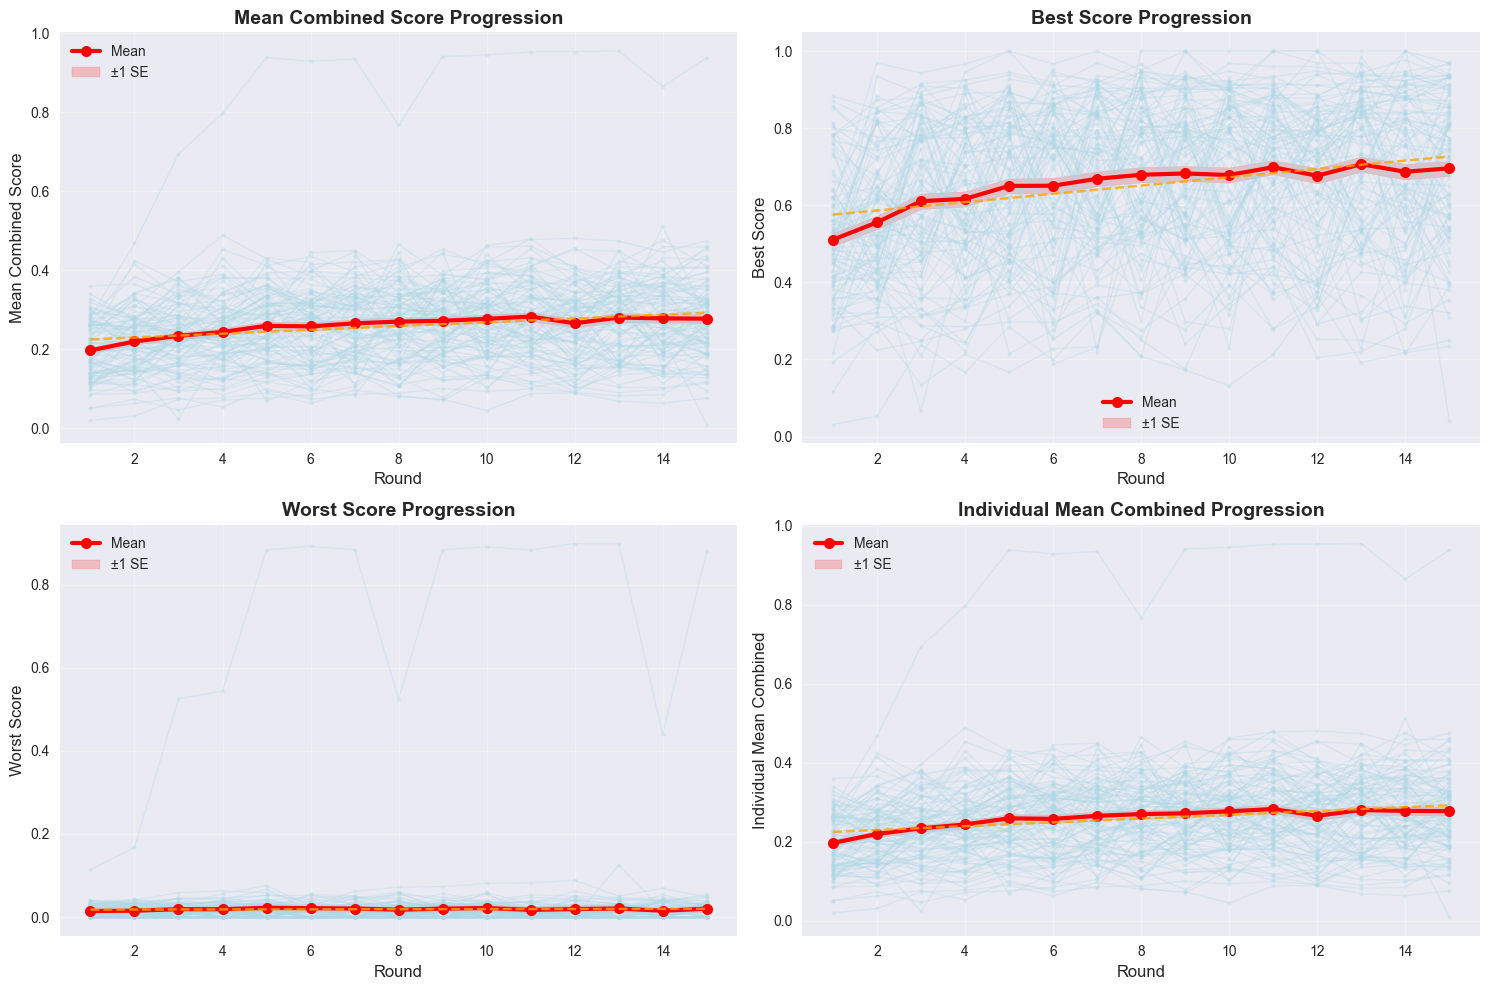

: 

In [ ]:
def main():
    """Main analysis pipeline"""
    try:
        # Create analyzer instance
        analyzer = RoundAnalyzer(users_directory="data/filtered_users")
        
        # Get raw data
        print("Loading data...")
        df = analyzer.analyze_all_users()
        print(f"Loaded {len(df)} records")
        
        # Extract metrics
        print("Extracting metrics...")
        df_metrics = extract_metrics(df)
        print(f"Extracted {len(df_metrics)} metric records")
        
        # Basic statistics
        print("\nBasic Statistics:")
        print(df_metrics.describe())
        
        # Round-by-round analysis
        aggregated_results = get_round_statistics(df_metrics)
        print("\nAggregated Results by Round:")
        print(aggregated_results)
        
        # Statistical significance testing
        significance_results = analyze_round_improvements(df_metrics)
        if not significance_results.empty:
            print("\nStatistical Significance Tests:")
            print(significance_results)
        
        # Performance distribution analysis
        analyze_performance_distribution(df_metrics)
        
        # Visualizations
        print("\nGenerating visualizations...")
        plot_metric_progression(df_metrics)
        
        return df_metrics, aggregated_results
        
    except Exception as e:
        print(f"Error in main analysis: {e}")
        return None, None

if __name__ == "__main__":
    df_metrics, aggregated_results = main()

# Individual metrics 

In [8]:
import scipy
scipy.__version__  # Ensure scipy is imported correctly

'1.13.1'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy 
from scipy import stats
import warnings
import os # --- IMPROVEMENT: Added for file path operations ---
import re # --- IMPROVEMENT: Added for sanitizing filenames ---

warnings.filterwarnings('ignore')

# --- IMPROVEMENT: Helper function to create valid filenames from titles ---
def _sanitize_filename(title):
    """Sanitizes a string to be a valid filename."""
    title = title.replace(' ', '_').replace(':', '_')
    return re.sub(r'[^a-zA-Z0-9_.-]', '', title)

def create_comprehensive_metric_plots(df_metrics, metric_name, save_dir=None):
    """
    Create 3 comprehensive plots for a single metric and optionally save them.
    
    Args:
        df_metrics (pd.DataFrame): The dataframe with metrics data.
        metric_name (str): The name of the metric column to analyze.
        save_dir (str, optional): Directory to save plots and stats. Defaults to None.
    """
    if metric_name not in df_metrics.columns:
        print(f"Metric '{metric_name}' not found in data")
        return
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    title_text = f'Comprehensive Analysis: {metric_name.replace("_", " ").title()}'
    fig.suptitle(title_text, fontsize=16, fontweight='bold')
    
    # Plot 1: Box plot by round
    ax1 = axes[0, 0]
    rounds = sorted(df_metrics['round'].unique())
    box_data = [df_metrics[df_metrics['round'] == r][metric_name].dropna() for r in rounds]
    bp = ax1.boxplot(box_data, labels=rounds, patch_artist=True, medianprops=dict(color='black'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(rounds)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax1.set_title('Distribution by Round', fontweight='bold')
    ax1.set_xlabel('Round')
    ax1.set_ylabel(metric_name.replace("_", " ").title())
    ax1.grid(True, alpha=0.3)
    for i, round_num in enumerate(rounds):
        round_data = df_metrics[df_metrics['round'] == round_num][metric_name].dropna()
        if len(round_data) > 0:
            median_val = round_data.median()
            ax1.text(i+1, median_val, f'{median_val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9, color='black')

    # Plot 2: Line plot with individual users + mean
    ax2 = axes[0, 1]
    for user_id in df_metrics['user_id'].unique():
        user_data = df_metrics[df_metrics['user_id'] == user_id].sort_values('round')
        if len(user_data) > 1:
            ax2.plot(user_data['round'], user_data[metric_name], alpha=0.3, color='lightblue', linewidth=1, marker='o', markersize=3)
    round_stats = df_metrics.groupby('round')[metric_name].agg(['mean', 'std', 'count'])
    ax2.plot(round_stats.index, round_stats['mean'], color='red', linewidth=3, marker='o', markersize=8, label='Mean')
    if (round_stats['count'] >= 2).all() and not round_stats['std'].isna().all():
        stderr = round_stats['std'] / np.sqrt(round_stats['count'])
        ax2.fill_between(round_stats.index, round_stats['mean'] - stderr, round_stats['mean'] + stderr, alpha=0.2, color='red', label='±1 SE')
    if len(round_stats) > 1:
        try:
            z = np.polyfit(round_stats.index, round_stats['mean'].dropna(), 1)
            p = np.poly1d(z)
            ax2.plot(round_stats.index, p(round_stats.index), linestyle='--', color='orange', alpha=0.8, label='Trend')
            slope = z[0]
            trend_text = f"Trend: {slope:+.4f}/round"
            ax2.text(0.05, 0.95, trend_text, transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        except np.linalg.LinAlgError:
            pass # Not enough data for trendline
    ax2.set_title('Progression Over Rounds', fontweight='bold')
    ax2.set_xlabel('Round')
    ax2.set_ylabel(metric_name.replace("_", " ").title())
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(rounds)

    # Plot 3: Histogram by round
    ax3 = axes[1, 0]
    colors_hist = plt.cm.viridis(np.linspace(0, 1, len(rounds)))
    for i, round_num in enumerate(rounds):
        round_data = df_metrics[df_metrics['round'] == round_num][metric_name].dropna()
        if len(round_data) > 0:
            sns.kdeplot(round_data, ax=ax3, label=f'Round {round_num}', color=colors_hist[i], fill=True, alpha=0.3)
    ax3.set_title('Distribution Shape by Round (KDE)', fontweight='bold')
    ax3.set_xlabel(metric_name.replace("_", " ").title())
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Statistical summary visualization
    ax4 = axes[1, 1]
    
    # Create a statistical summary plot showing mean ± std for each round
    round_stats = df_metrics.groupby('round')[metric_name].agg(['mean', 'std', 'count', 'min', 'max']).reset_index()
    
    x_pos = np.arange(len(round_stats))
    bars = ax4.bar(x_pos, round_stats['mean'], yerr=round_stats['std'], 
                   capsize=5, alpha=0.7, color=plt.cm.viridis(np.linspace(0, 1, len(round_stats))))
    
    # Add value labels on bars
    for i, (bar, mean_val, count) in enumerate(zip(bars, round_stats['mean'], round_stats['count'])):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + round_stats['std'].iloc[i],
                f'{mean_val:.3f}\n(n={count})', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax4.set_title('Mean ± Standard Deviation by Round', fontweight='bold')
    ax4.set_xlabel('Round')
    ax4.set_ylabel(f'Mean {metric_name.replace("_", " ").title()}')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels([f'Round {r}' for r in round_stats['round']])
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add range indicators (min-max)
    for i, (min_val, max_val) in enumerate(zip(round_stats['min'], round_stats['max'])):
        ax4.plot([i, i], [min_val, max_val], color='red', alpha=0.6, linewidth=2, label='Range' if i == 0 else "")
        ax4.scatter([i, i], [min_val, max_val], color='red', alpha=0.8, s=30, zorder=5)
    
    if len(round_stats) > 0:
        ax4.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # --- IMPROVEMENT: Save the figure ---
    if save_dir:
        filename = _sanitize_filename(title_text)
        filepath = os.path.join(save_dir, f"{filename}.png")
        fig.savefig(filepath, dpi=150, bbox_inches='tight')
        print(f"✅ Plot saved to {filepath}")
        
    plt.show()
    plt.close(fig) # --- IMPROVEMENT: Free up memory ---
    
    # --- IMPROVEMENT: Encapsulate stats text generation for saving ---
    stats_text = []
    stats_text.append(f"=== SUMMARY STATISTICS FOR {metric_name.upper()} ===")
    stats_text.append("\nOverall Statistics:")
    stats_text.append(f"  Mean: {df_metrics[metric_name].mean():.4f}")
    stats_text.append(f"  Std:  {df_metrics[metric_name].std():.4f}")
    stats_text.append(f"  Min:  {df_metrics[metric_name].min():.4f}")
    stats_text.append(f"  Max:  {df_metrics[metric_name].max():.4f}")
    
    stats_text.append("\nBy Round:")
    round_summary = df_metrics.groupby('round')[metric_name].agg(['count', 'mean', 'std', 'min', 'max']).round(4)
    stats_text.append(round_summary.to_string())
    
    stats_text.append("\n\nStatistical Tests (Welch's t-test between consecutive rounds):")
    for i in range(len(rounds) - 1):
        r1_data = df_metrics[df_metrics['round'] == rounds[i]][metric_name].dropna()
        r2_data = df_metrics[df_metrics['round'] == rounds[i+1]][metric_name].dropna()
        
        if len(r1_data) > 1 and len(r2_data) > 1:
            # --- IMPROVEMENT: Use Welch's t-test (more robust) ---
            t_stat, p_value = stats.ttest_ind(r1_data, r2_data, equal_var=False)
            mean_diff = r2_data.mean() - r1_data.mean()
            pct_change = (mean_diff / r1_data.mean() * 100) if r1_data.mean() != 0 else float('inf')
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            stats_text.append(f"  Round {rounds[i]} → {rounds[i+1]}: Δ={mean_diff:+.4f} ({pct_change:+.1f}%), p={p_value:.4f} {significance}")
        else:
            stats_text.append(f"  Round {rounds[i]} → {rounds[i+1]}: Not enough data for test")

    full_stats_text = "\n".join(stats_text)
    print(full_stats_text)
    
    # --- IMPROVEMENT: Save the stats summary ---
    if save_dir:
        filename = _sanitize_filename(title_text)
        filepath = os.path.join(save_dir, f"{filename}_stats.txt")
        with open(filepath, 'w') as f:
            f.write(full_stats_text)
        print(f"✅ Statistics saved to {filepath}")

def analyze_all_metrics_individually(df_metrics, save_dir=None, interactive=True):
    """
    Analyze all metrics individually with comprehensive plots.
    
    Args:
        df_metrics (pd.DataFrame): The dataframe with metrics data.
        save_dir (str, optional): Directory to save all generated files.
        interactive (bool, optional): If True, pauses after each metric for user input.
    """
    numeric_cols = df_metrics.select_dtypes(include=['number']).columns
    metric_cols = [col for col in numeric_cols if col not in ['round', 'user_id']]
    
    print(f"=== ANALYZING {len(metric_cols)} METRICS INDIVIDUALLY ===")
    
    for metric in metric_cols:
        print(f"\n{'-'*60}\nANALYZING: {metric}\n{'-'*60}")
        try:
            create_comprehensive_metric_plots(df_metrics, metric, save_dir=save_dir)
        except Exception as e:
            print(f"❌ Error analyzing {metric}: {e}")
            continue
        
        # --- IMPROVEMENT: Make interactive mode optional ---
        if interactive:
            user_input = input("\nPress Enter to continue to next metric, or 'q' to quit: ")
            if user_input.lower() == 'q':
                print("Analysis halted by user.")
                return

def create_metric_comparison_dashboard(df_metrics):
    """Create a dashboard comparing key metrics side by side"""
    
    # Select key metrics for comparison
    key_metrics = [
        'mean_combined_score', 'best_score', 'worst_score',
        'individual_mean_combined', 'overall_rouge1', 'overall_bleu'
    ]
    
    # Filter to existing metrics
    available_metrics = [m for m in key_metrics if m in df_metrics.columns]
    
    if len(available_metrics) < 2:
        print("Not enough metrics available for comparison dashboard")
        return
    
    # Create comparison plots
    n_metrics = len(available_metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    fig.suptitle('Key Metrics Comparison Dashboard', fontsize=16, fontweight='bold')
    
    for i, metric in enumerate(available_metrics):
        ax = axes[i]
        
        # Box plot by round
        rounds = sorted(df_metrics['round'].unique())
        box_data = [df_metrics[df_metrics['round'] == r][metric].dropna() for r in rounds]
        
        bp = ax.boxplot(box_data, labels=rounds, patch_artist=True)
        
        # Color the boxes
        colors = plt.cm.Set3(np.linspace(0, 1, len(rounds)))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Add mean line
        round_means = df_metrics.groupby('round')[metric].mean()
        ax.plot(range(1, len(rounds)+1), round_means.values, 
               color='red', linewidth=2, marker='D', markersize=6, label='Mean')
        
        ax.set_title(f'{metric.replace("_", " ").title()}', fontweight='bold')
        ax.set_xlabel('Round')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add trend annotation
        if len(round_means) > 2:
            try:
                slope = np.polyfit(round_means.index, round_means.values, 1)[0]
                trend_color = 'green' if slope > 0 else 'red' if slope < 0 else 'gray'
                trend_symbol = '↗' if slope > 0 else '↘' if slope < 0 else '→'
                ax.text(0.02, 0.98, f'{trend_symbol} {slope:.4f}', transform=ax.transAxes,
                       verticalalignment='top', color=trend_color, fontweight='bold', fontsize=12)
            except:
                pass
    
    # Remove empty subplots
    for i in range(len(available_metrics), len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

# Main function to run all individual analyses
def run_comprehensive_individual_analysis(df_metrics):
    """Run the complete individual metric analysis suite"""
    
    print("=== COMPREHENSIVE INDIVIDUAL METRIC ANALYSIS ===")
    print("This will analyze each metric with 3 different visualizations:")
    print("1. Box plot by round (distribution)")
    print("2. Line plot with trend (progression)")  
    print("3. Histogram by round (distribution shape)")
    print("4. Statistical summary (mean ± std by round)")
    print("\nStarting analysis...\n")
    
    # First show the comparison dashboard
    print("=== KEY METRICS COMPARISON DASHBOARD ===")
    create_metric_comparison_dashboard(df_metrics)
    
    # Then analyze each metric individually
    analyze_all_metrics_individually(df_metrics)
    
    print("\n=== ANALYSIS COMPLETE ===")

--- Running analysis for a single metric ---


--- Running analysis for ALL metrics (non-interactive) ---
=== ANALYZING 12 METRICS INDIVIDUALLY ===

------------------------------------------------------------
ANALYZING: mean_combined_score
------------------------------------------------------------
✅ Plot saved to output/metric_analysis_first_run/Comprehensive_Analysis__Mean_Combined_Score.png


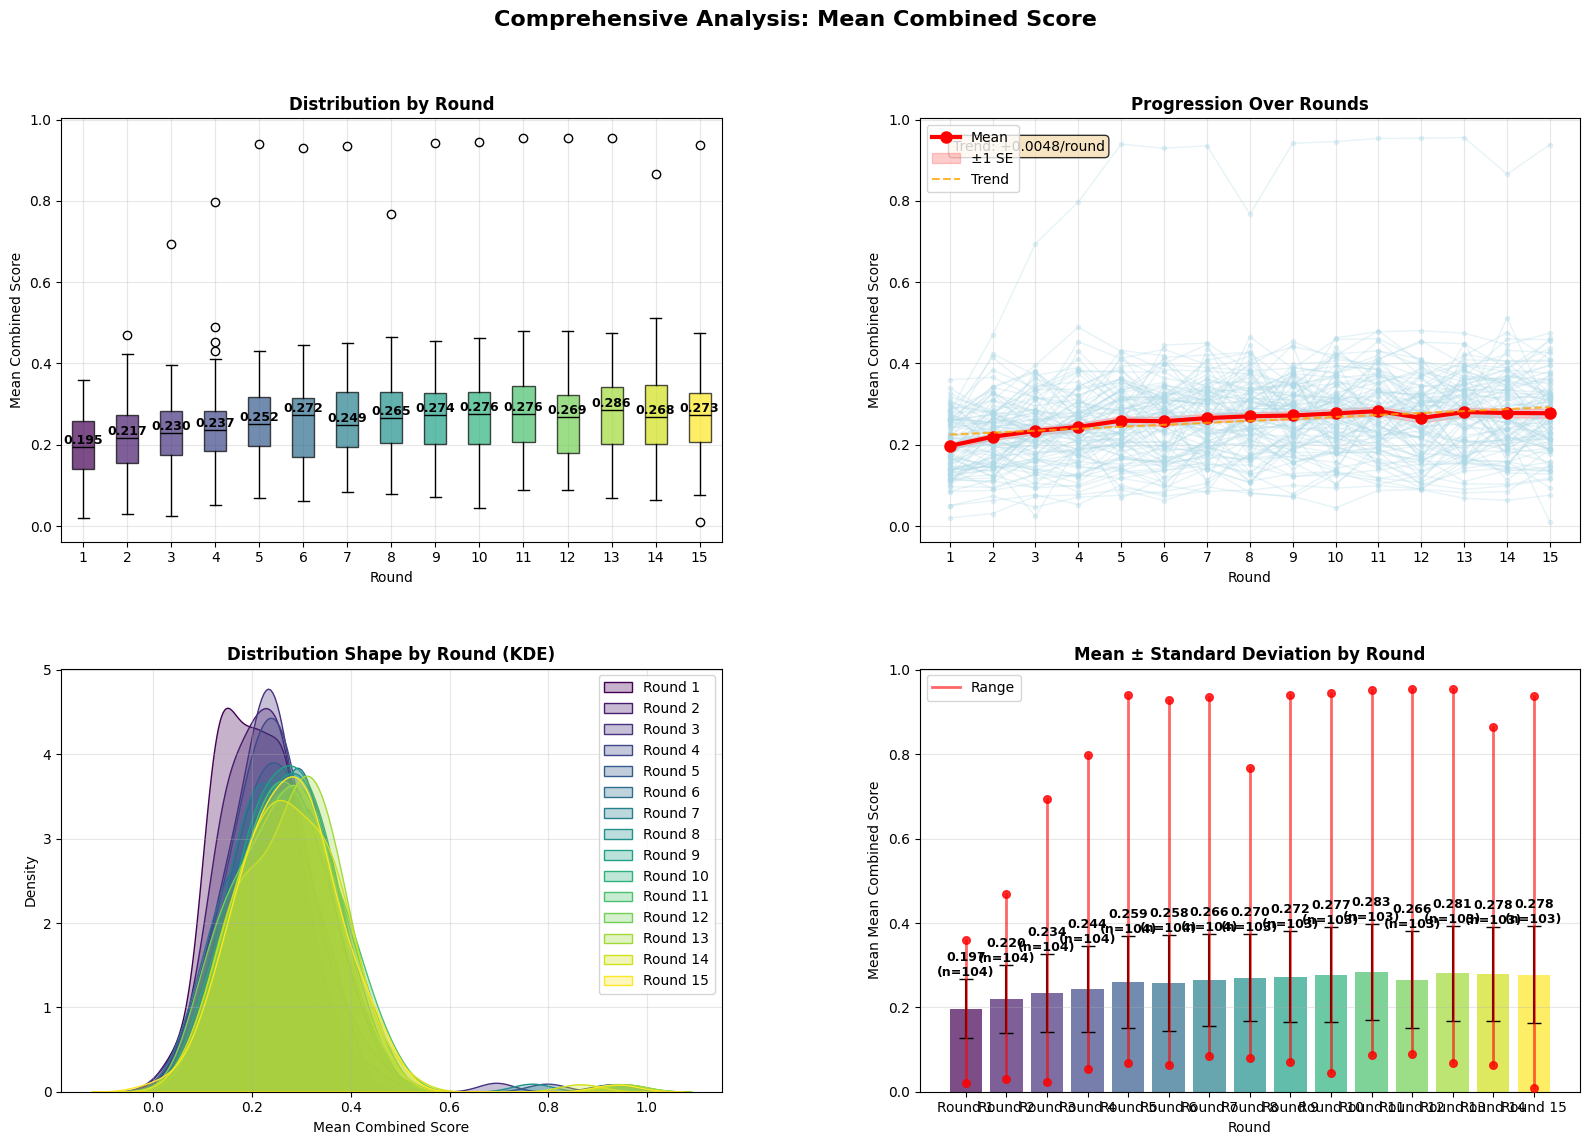

=== SUMMARY STATISTICS FOR MEAN_COMBINED_SCORE ===

Overall Statistics:
  Mean: 0.2588
  Std:  0.1075
  Min:  0.0095
  Max:  0.9556

By Round:
       count    mean     std     min     max
round                                       
1        104  0.1972  0.0709  0.0201  0.3601
2        104  0.2199  0.0811  0.0311  0.4690
3        104  0.2341  0.0916  0.0239  0.6944
4        104  0.2439  0.1017  0.0531  0.7975
5        104  0.2595  0.1088  0.0685  0.9394
6        104  0.2581  0.1131  0.0630  0.9293
7        104  0.2657  0.1094  0.0837  0.9353
8        103  0.2702  0.1027  0.0802  0.7672
9        103  0.2722  0.1080  0.0712  0.9416
10       103  0.2773  0.1126  0.0450  0.9458
11       103  0.2829  0.1138  0.0879  0.9535
12       103  0.2660  0.1151  0.0895  0.9539
13       103  0.2805  0.1135  0.0686  0.9556
14       103  0.2783  0.1113  0.0636  0.8656
15       103  0.2777  0.1141  0.0095  0.9384


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0226 (+

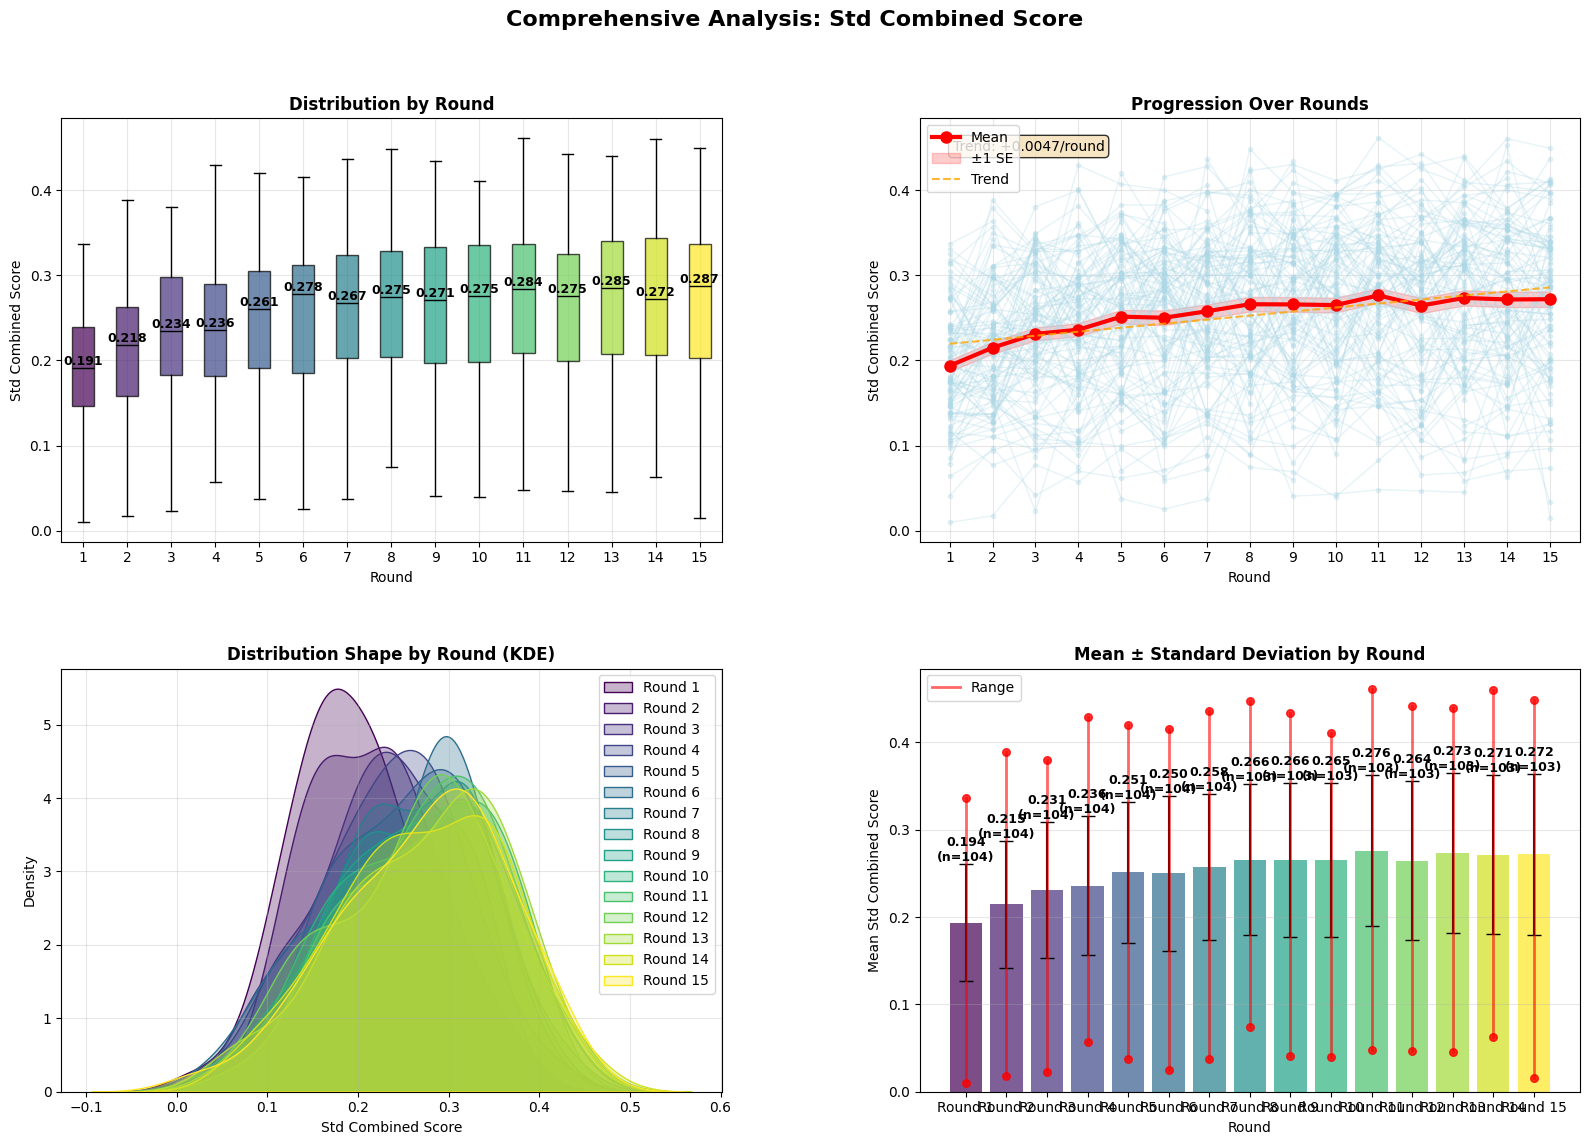

=== SUMMARY STATISTICS FOR STD_COMBINED_SCORE ===

Overall Statistics:
  Mean: 0.2525
  Std:  0.0873
  Min:  0.0099
  Max:  0.4616

By Round:
       count    mean     std     min     max
round                                       
1        104  0.1937  0.0673  0.0099  0.3365
2        104  0.2149  0.0727  0.0175  0.3885
3        104  0.2311  0.0778  0.0226  0.3803
4        104  0.2360  0.0800  0.0572  0.4290
5        104  0.2513  0.0807  0.0377  0.4196
6        104  0.2500  0.0887  0.0254  0.4154
7        104  0.2576  0.0834  0.0375  0.4365
8        103  0.2659  0.0869  0.0744  0.4477
9        103  0.2657  0.0879  0.0405  0.4341
10       103  0.2649  0.0882  0.0397  0.4111
11       103  0.2762  0.0859  0.0482  0.4616
12       103  0.2644  0.0909  0.0468  0.4421
13       103  0.2733  0.0912  0.0450  0.4395
14       103  0.2715  0.0909  0.0626  0.4602
15       103  0.2718  0.0922  0.0153  0.4491


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0211 (+1

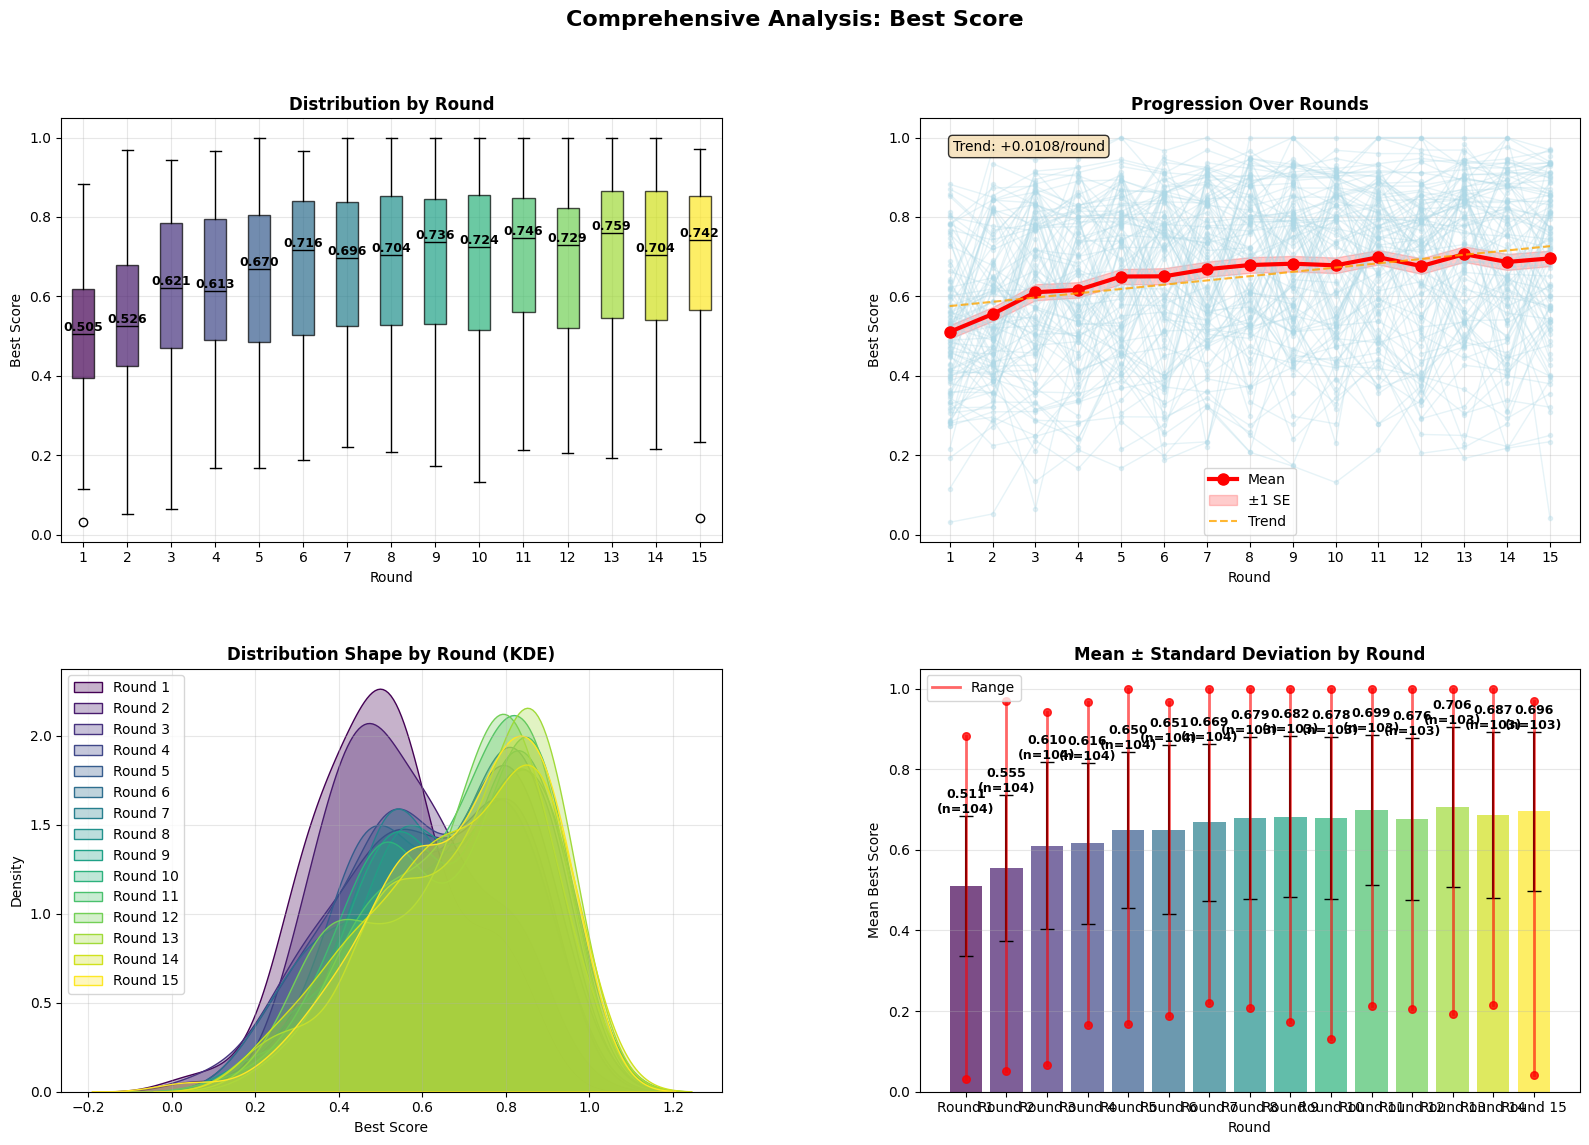

=== SUMMARY STATISTICS FOR BEST_SCORE ===

Overall Statistics:
  Mean: 0.6509
  Std:  0.2034
  Min:  0.0311
  Max:  1.0000

By Round:
       count    mean     std     min     max
round                                       
1        104  0.5106  0.1741  0.0311  0.8823
2        104  0.5554  0.1803  0.0522  0.9687
3        104  0.6105  0.2077  0.0655  0.9433
4        104  0.6164  0.1998  0.1666  0.9665
5        104  0.6501  0.1940  0.1673  1.0000
6        104  0.6506  0.2097  0.1872  0.9665
7        104  0.6685  0.1947  0.2197  1.0000
8        103  0.6790  0.2016  0.2077  1.0000
9        103  0.6824  0.1994  0.1725  1.0000
10       103  0.6783  0.2009  0.1316  1.0000
11       103  0.6986  0.1853  0.2130  1.0000
12       103  0.6764  0.2006  0.2048  1.0000
13       103  0.7064  0.1994  0.1919  1.0000
14       103  0.6867  0.2060  0.2154  1.0000
15       103  0.6957  0.1976  0.0414  0.9705


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0448 (+8.8%), p=

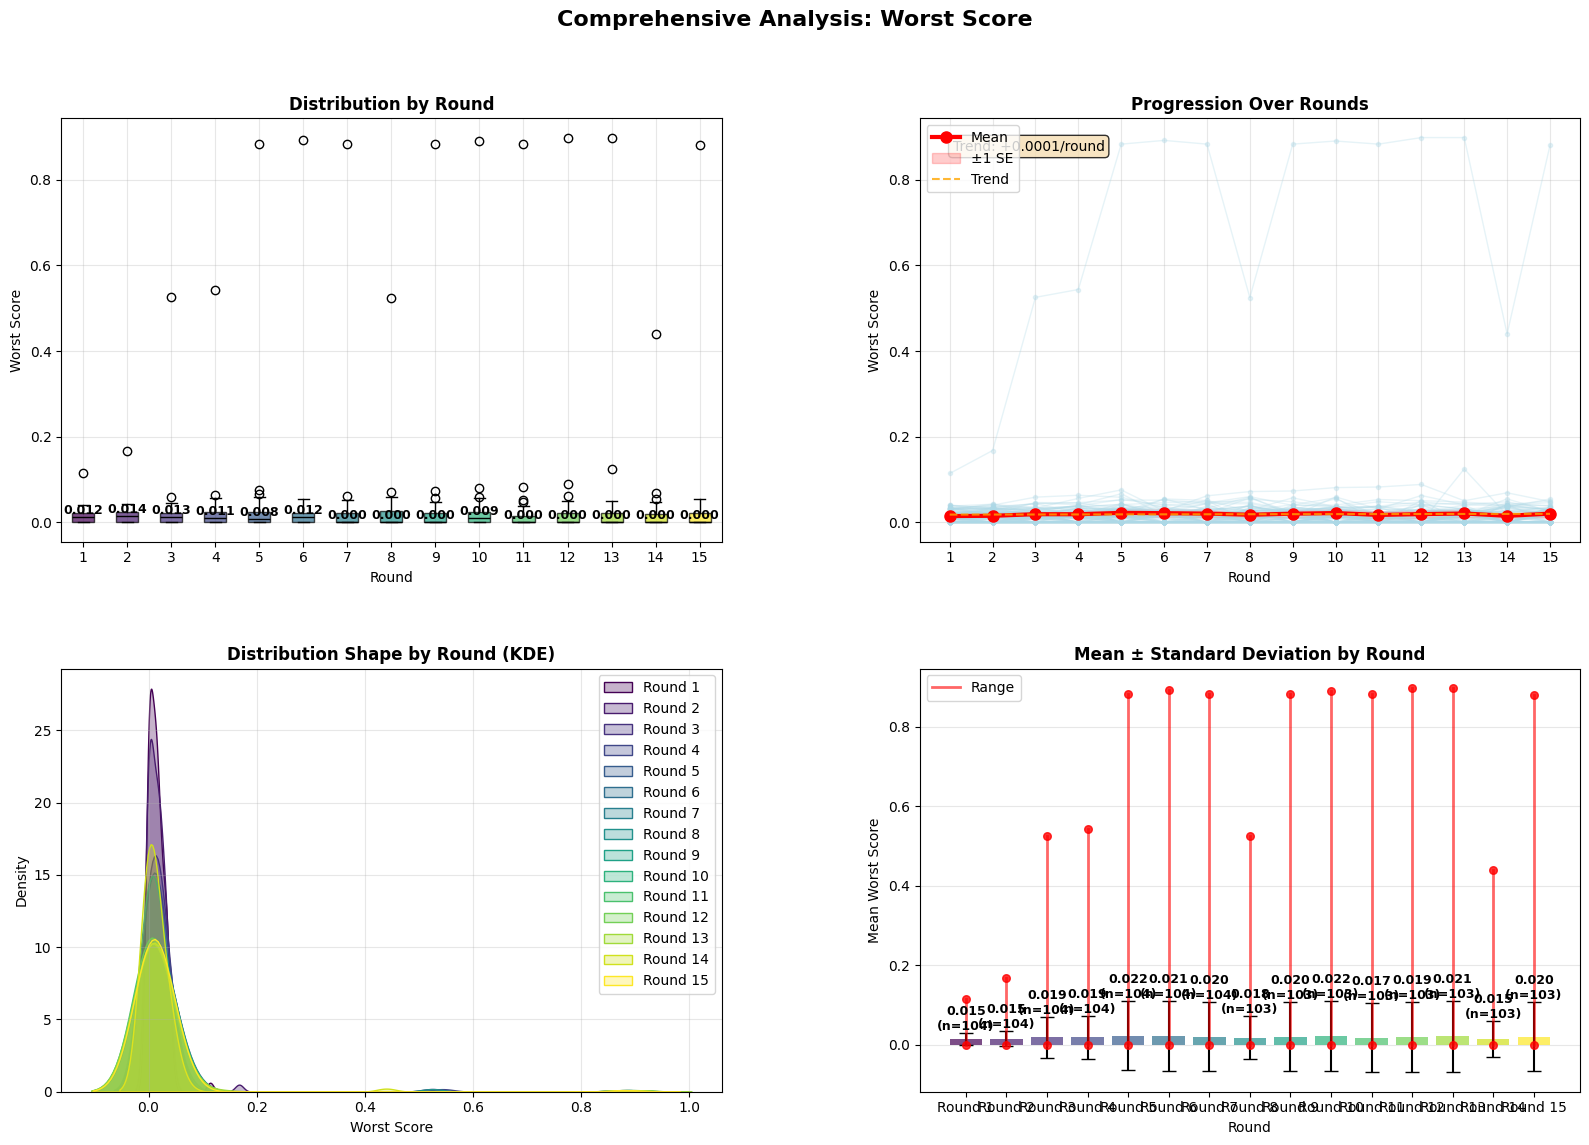

=== SUMMARY STATISTICS FOR WORST_SCORE ===

Overall Statistics:
  Mean: 0.0189
  Std:  0.0728
  Min:  0.0000
  Max:  0.8986

By Round:
       count    mean     std  min     max
round                                    
1        104  0.0145  0.0156  0.0  0.1141
2        104  0.0152  0.0198  0.0  0.1676
3        104  0.0190  0.0518  0.0  0.5254
4        104  0.0188  0.0541  0.0  0.5438
5        104  0.0221  0.0870  0.0  0.8833
6        104  0.0213  0.0874  0.0  0.8920
7        104  0.0204  0.0868  0.0  0.8833
8        103  0.0177  0.0533  0.0  0.5249
9        103  0.0201  0.0872  0.0  0.8833
10       103  0.0217  0.0880  0.0  0.8906
11       103  0.0172  0.0874  0.0  0.8833
12       103  0.0192  0.0891  0.0  0.8986
13       103  0.0206  0.0892  0.0  0.8986
14       103  0.0152  0.0453  0.0  0.4399
15       103  0.0201  0.0869  0.0  0.8805


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0007 (+4.6%), p=0.7859 ns
  Round 2 → 3: Δ=+0.0037 (+24.6%), p=0.4

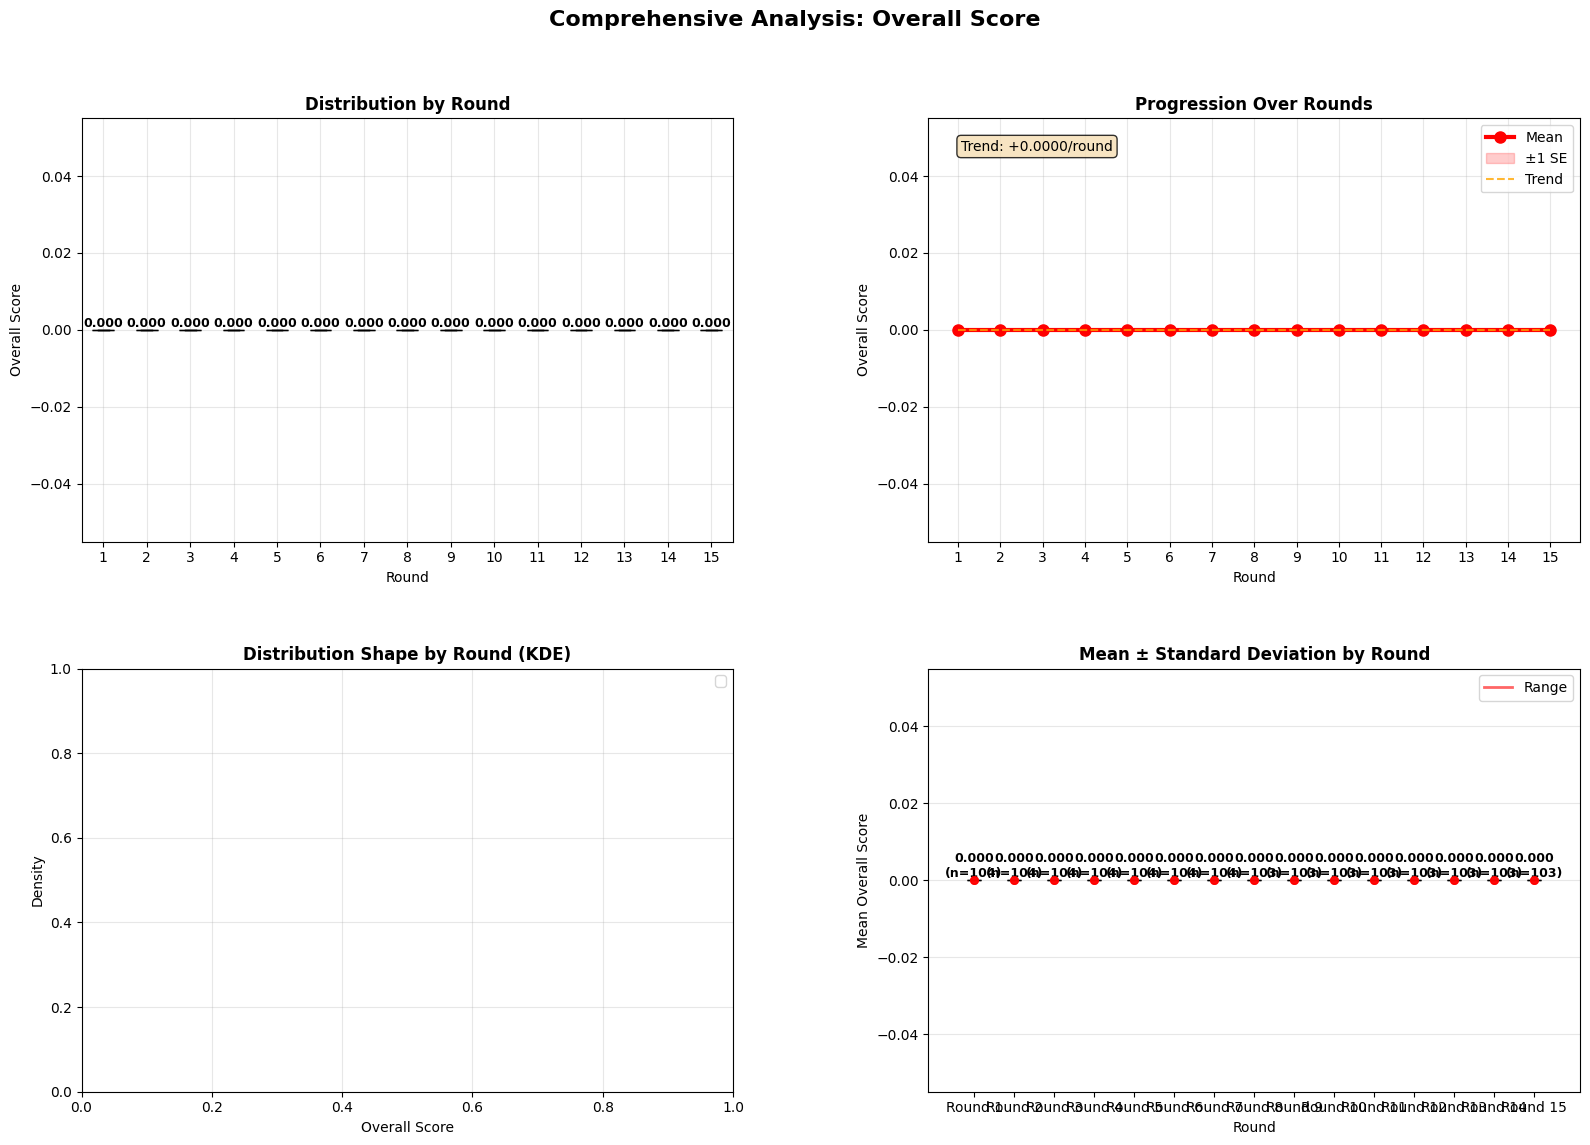

=== SUMMARY STATISTICS FOR OVERALL_SCORE ===

Overall Statistics:
  Mean: 0.0000
  Std:  0.0000
  Min:  0.0000
  Max:  0.0000

By Round:
       count  mean  std  min  max
round                            
1        104   0.0  0.0    0    0
2        104   0.0  0.0    0    0
3        104   0.0  0.0    0    0
4        104   0.0  0.0    0    0
5        104   0.0  0.0    0    0
6        104   0.0  0.0    0    0
7        104   0.0  0.0    0    0
8        103   0.0  0.0    0    0
9        103   0.0  0.0    0    0
10       103   0.0  0.0    0    0
11       103   0.0  0.0    0    0
12       103   0.0  0.0    0    0
13       103   0.0  0.0    0    0
14       103   0.0  0.0    0    0
15       103   0.0  0.0    0    0


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0000 (+inf%), p=nan ns
  Round 2 → 3: Δ=+0.0000 (+inf%), p=nan ns
  Round 3 → 4: Δ=+0.0000 (+inf%), p=nan ns
  Round 4 → 5: Δ=+0.0000 (+inf%), p=nan ns
  Round 5 → 6: Δ=+0.0000 (+inf%), p=nan ns
  Rou

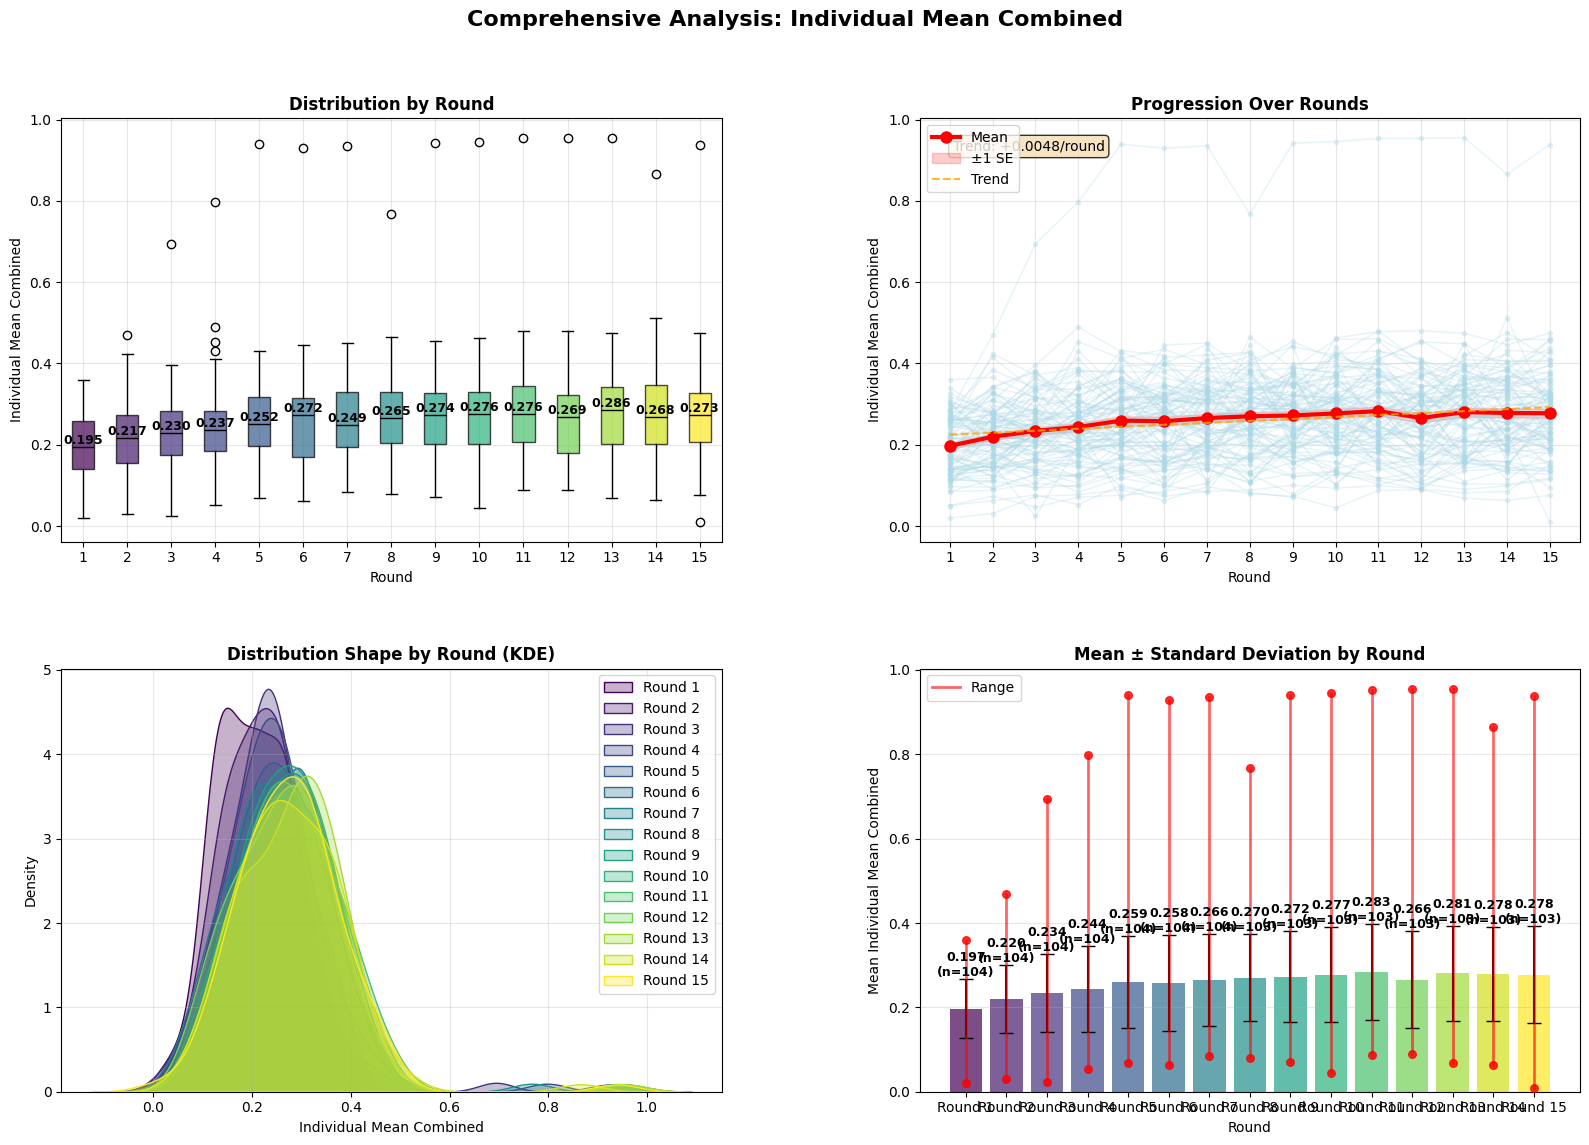

=== SUMMARY STATISTICS FOR INDIVIDUAL_MEAN_COMBINED ===

Overall Statistics:
  Mean: 0.2588
  Std:  0.1075
  Min:  0.0095
  Max:  0.9556

By Round:
       count    mean     std     min     max
round                                       
1        104  0.1972  0.0709  0.0201  0.3601
2        104  0.2199  0.0811  0.0311  0.4690
3        104  0.2341  0.0916  0.0239  0.6944
4        104  0.2439  0.1017  0.0531  0.7975
5        104  0.2595  0.1088  0.0685  0.9394
6        104  0.2581  0.1131  0.0630  0.9293
7        104  0.2657  0.1094  0.0837  0.9353
8        103  0.2702  0.1027  0.0802  0.7672
9        103  0.2722  0.1080  0.0712  0.9416
10       103  0.2773  0.1126  0.0450  0.9458
11       103  0.2829  0.1138  0.0879  0.9535
12       103  0.2660  0.1151  0.0895  0.9539
13       103  0.2805  0.1135  0.0686  0.9556
14       103  0.2783  0.1113  0.0636  0.8656
15       103  0.2777  0.1141  0.0095  0.9384


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.02

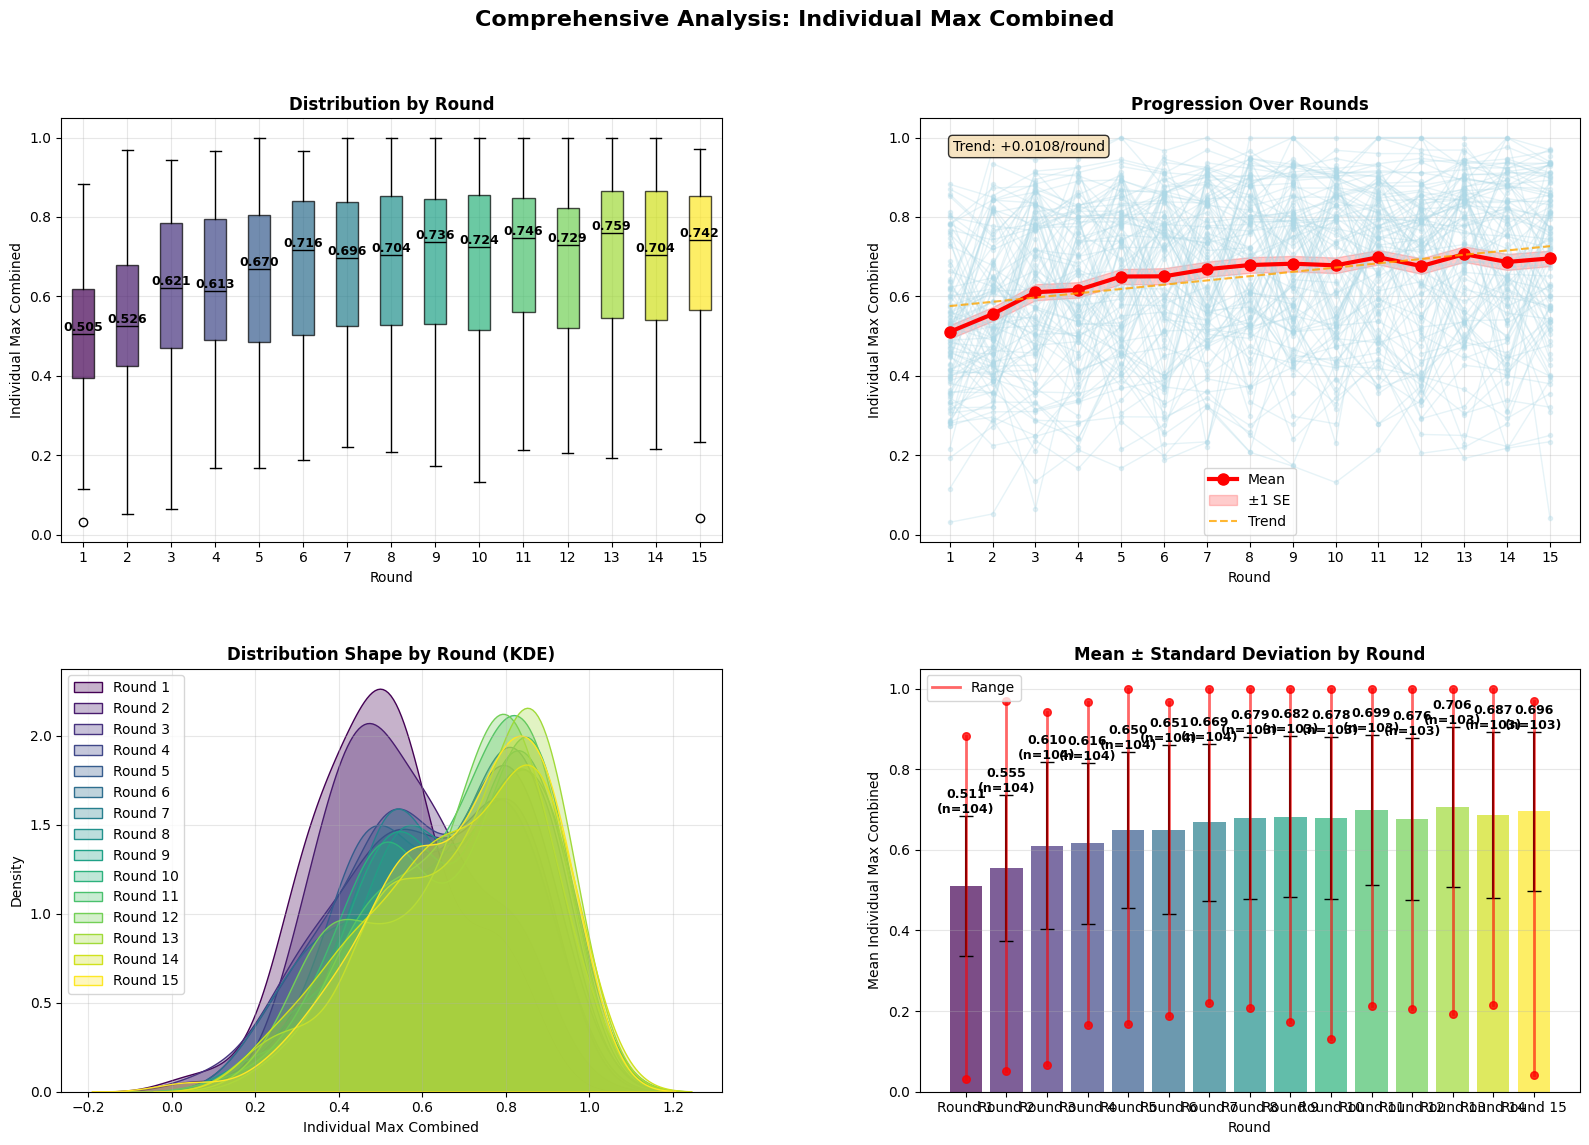

=== SUMMARY STATISTICS FOR INDIVIDUAL_MAX_COMBINED ===

Overall Statistics:
  Mean: 0.6509
  Std:  0.2034
  Min:  0.0311
  Max:  1.0000

By Round:
       count    mean     std     min     max
round                                       
1        104  0.5106  0.1741  0.0311  0.8823
2        104  0.5554  0.1803  0.0522  0.9687
3        104  0.6105  0.2077  0.0655  0.9433
4        104  0.6164  0.1998  0.1666  0.9665
5        104  0.6501  0.1940  0.1673  1.0000
6        104  0.6506  0.2097  0.1872  0.9665
7        104  0.6685  0.1947  0.2197  1.0000
8        103  0.6790  0.2016  0.2077  1.0000
9        103  0.6824  0.1994  0.1725  1.0000
10       103  0.6783  0.2009  0.1316  1.0000
11       103  0.6986  0.1853  0.2130  1.0000
12       103  0.6764  0.2006  0.2048  1.0000
13       103  0.7064  0.1994  0.1919  1.0000
14       103  0.6867  0.2060  0.2154  1.0000
15       103  0.6957  0.1976  0.0414  0.9705


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.044

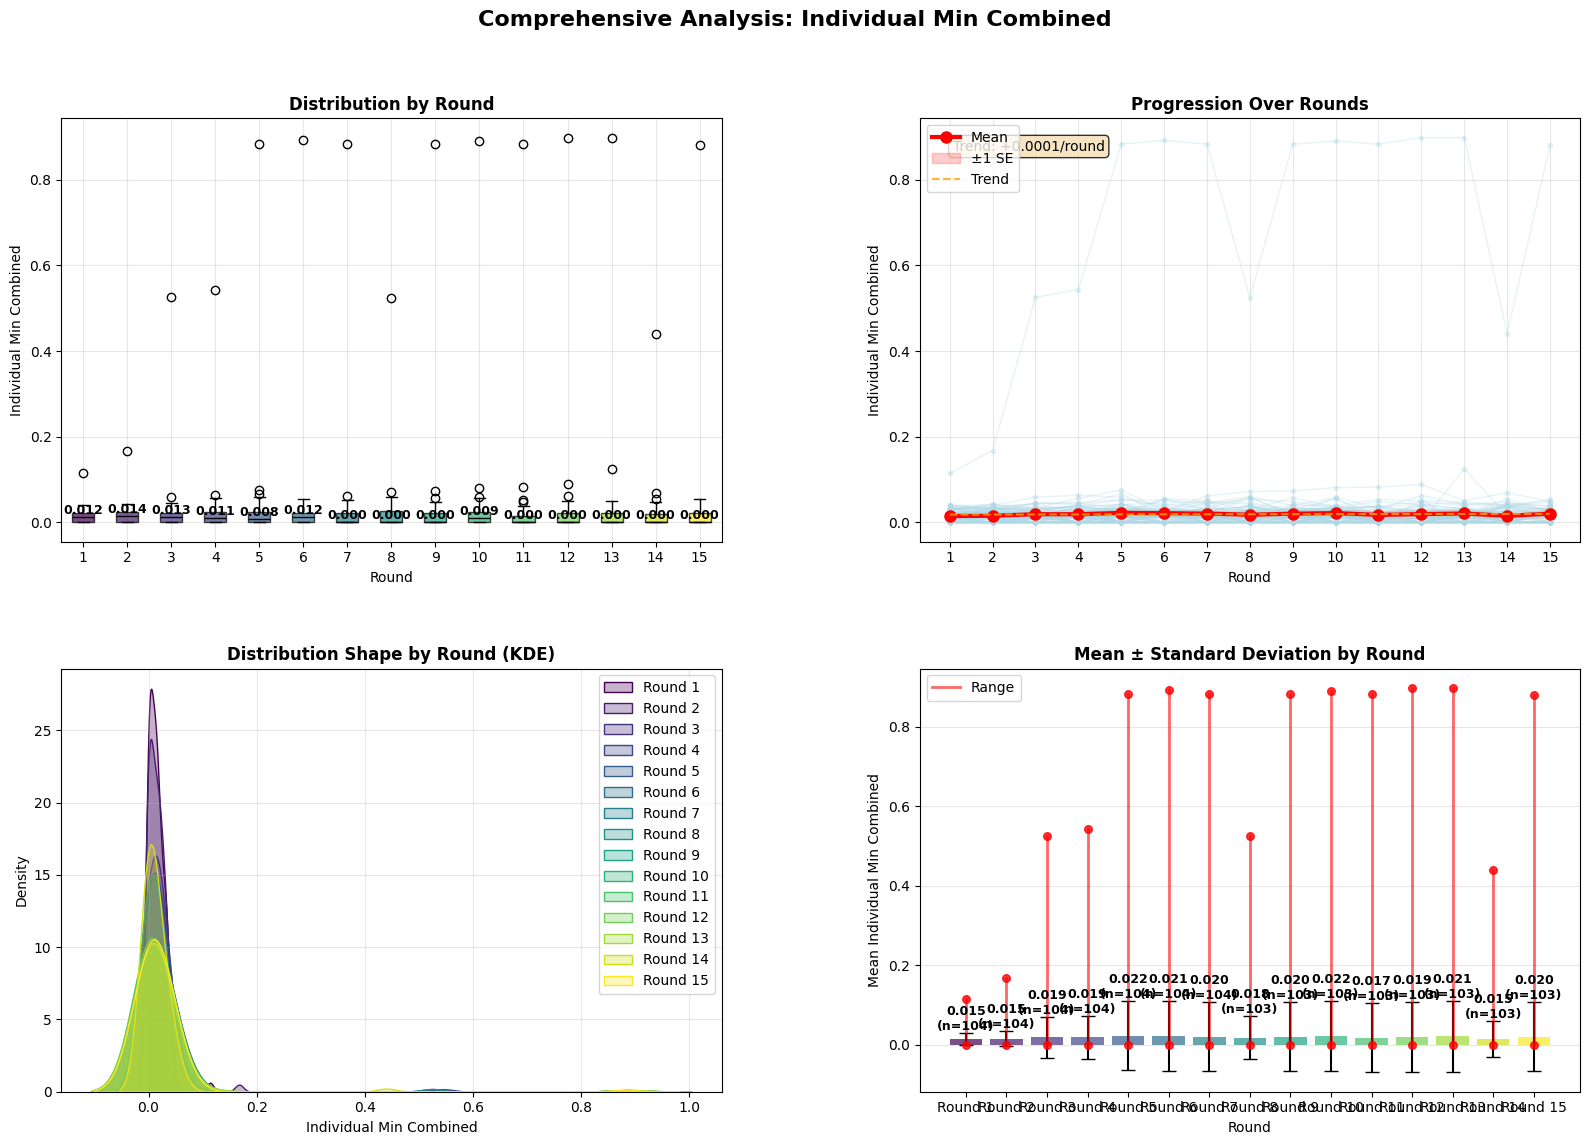

=== SUMMARY STATISTICS FOR INDIVIDUAL_MIN_COMBINED ===

Overall Statistics:
  Mean: 0.0189
  Std:  0.0728
  Min:  0.0000
  Max:  0.8986

By Round:
       count    mean     std  min     max
round                                    
1        104  0.0145  0.0156  0.0  0.1141
2        104  0.0152  0.0198  0.0  0.1676
3        104  0.0190  0.0518  0.0  0.5254
4        104  0.0188  0.0541  0.0  0.5438
5        104  0.0221  0.0870  0.0  0.8833
6        104  0.0213  0.0874  0.0  0.8920
7        104  0.0204  0.0868  0.0  0.8833
8        103  0.0177  0.0533  0.0  0.5249
9        103  0.0201  0.0872  0.0  0.8833
10       103  0.0217  0.0880  0.0  0.8906
11       103  0.0172  0.0874  0.0  0.8833
12       103  0.0192  0.0891  0.0  0.8986
13       103  0.0206  0.0892  0.0  0.8986
14       103  0.0152  0.0453  0.0  0.4399
15       103  0.0201  0.0869  0.0  0.8805


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0007 (+4.6%), p=0.7859 ns
  Round 2 → 3: Δ=+0.0037 (+2

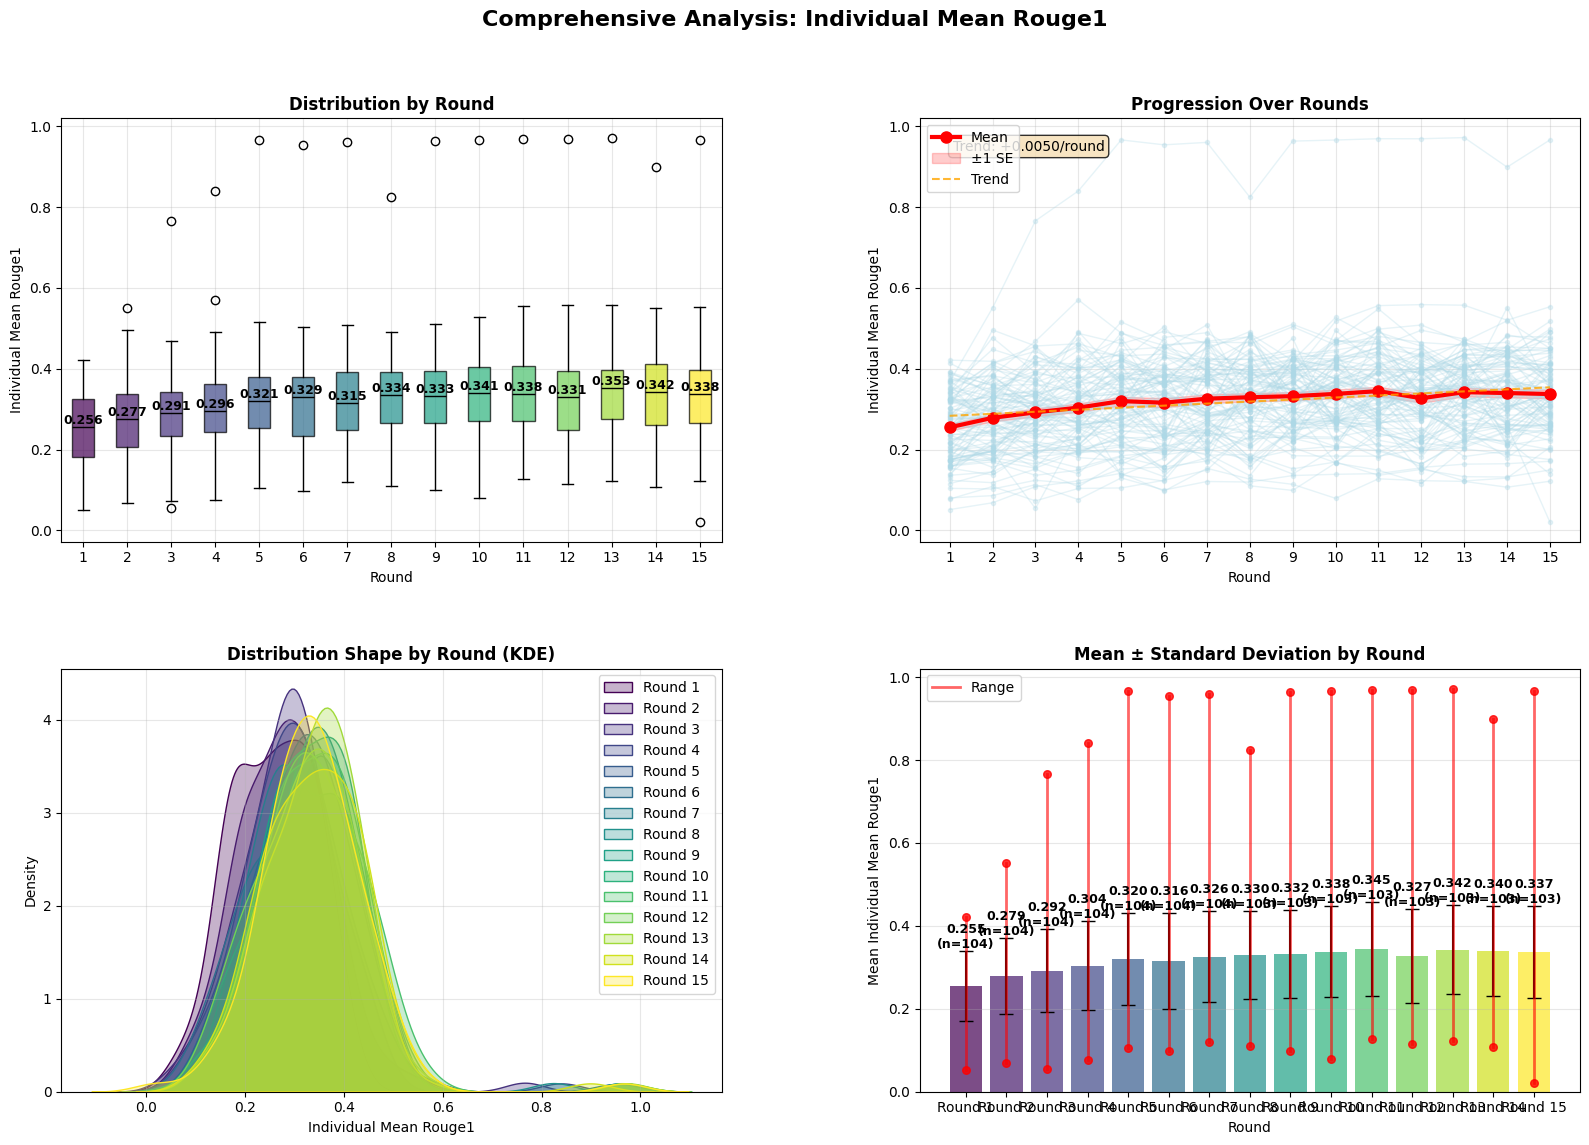

=== SUMMARY STATISTICS FOR INDIVIDUAL_MEAN_ROUGE1 ===

Overall Statistics:
  Mean: 0.3187
  Std:  0.1090
  Min:  0.0200
  Max:  0.9720

By Round:
       count    mean     std     min     max
round                                       
1        104  0.2551  0.0838  0.0516  0.4214
2        104  0.2786  0.0912  0.0684  0.5506
3        104  0.2921  0.0999  0.0545  0.7661
4        104  0.3038  0.1079  0.0763  0.8399
5        104  0.3200  0.1113  0.1050  0.9662
6        104  0.3159  0.1162  0.0973  0.9541
7        104  0.3260  0.1095  0.1210  0.9602
8        103  0.3295  0.1051  0.1103  0.8245
9        103  0.3321  0.1062  0.0990  0.9633
10       103  0.3378  0.1095  0.0794  0.9660
11       103  0.3447  0.1128  0.1277  0.9692
12       103  0.3270  0.1133  0.1161  0.9691
13       103  0.3421  0.1072  0.1213  0.9720
14       103  0.3399  0.1086  0.1069  0.8989
15       103  0.3374  0.1109  0.0200  0.9663


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0235

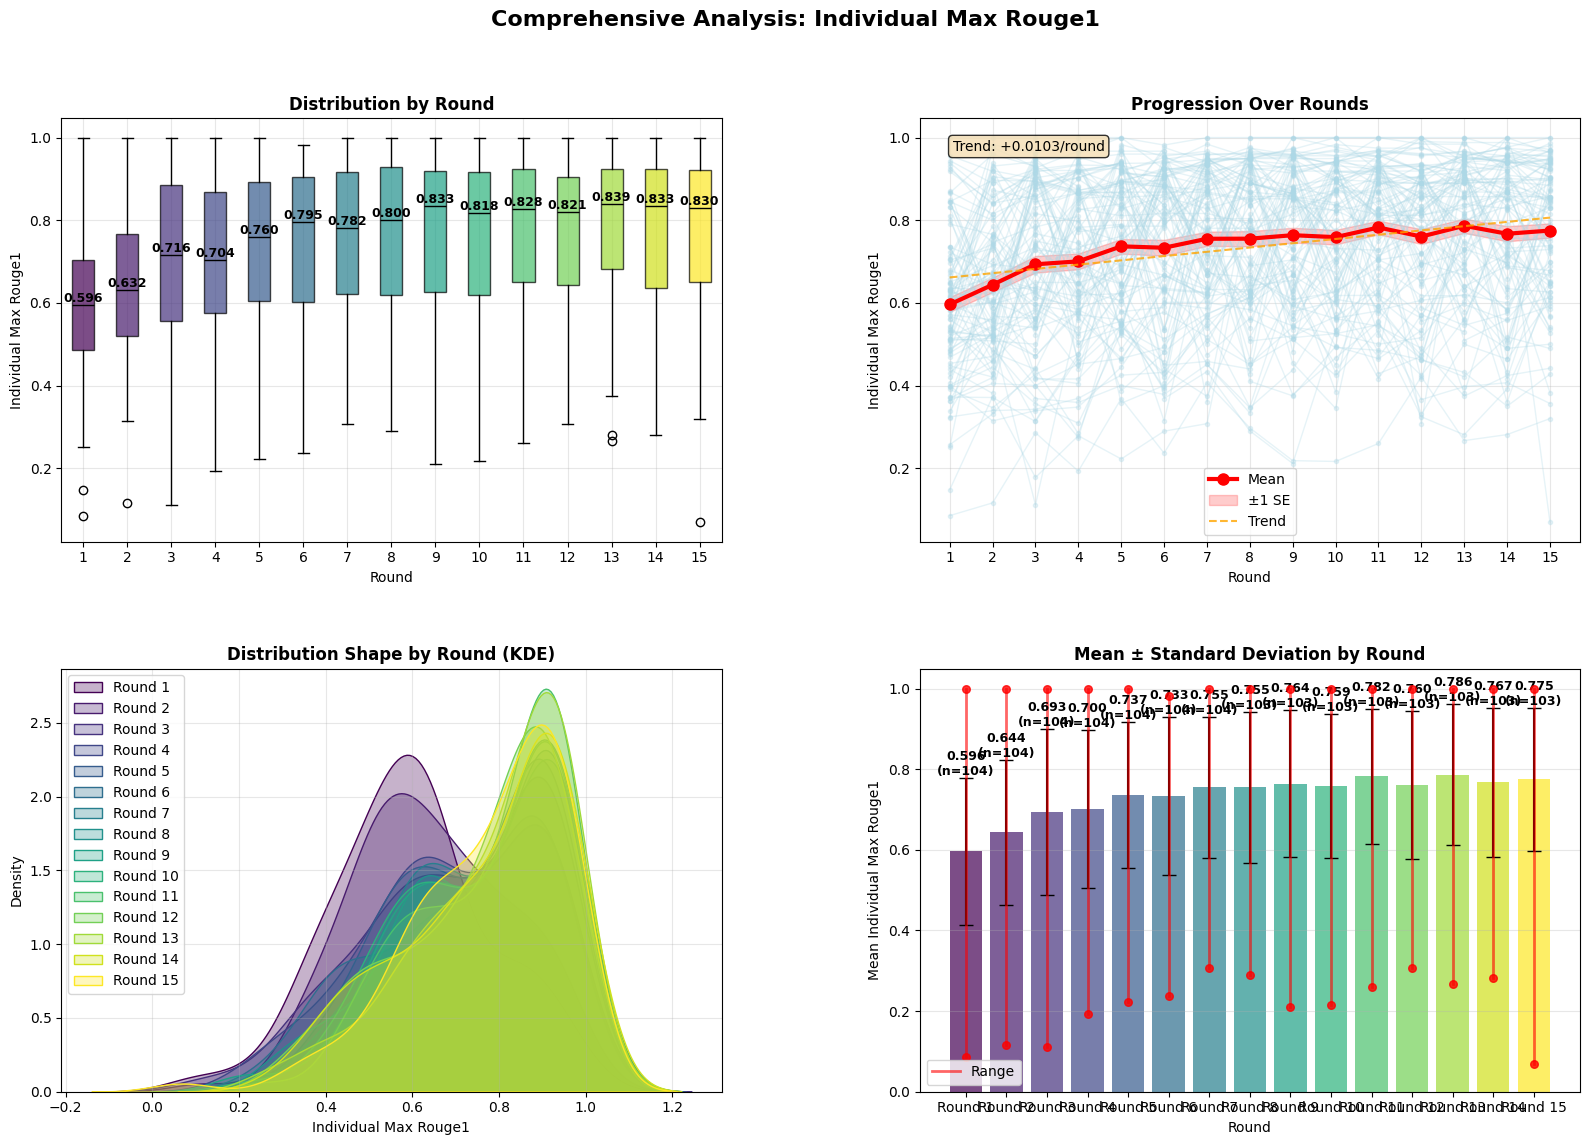

=== SUMMARY STATISTICS FOR INDIVIDUAL_MAX_ROUGE1 ===

Overall Statistics:
  Mean: 0.7337
  Std:  0.1904
  Min:  0.0690
  Max:  1.0000

By Round:
       count    mean     std     min     max
round                                       
1        104  0.5961  0.1817  0.0851  1.0000
2        104  0.6438  0.1802  0.1159  1.0000
3        104  0.6934  0.2061  0.1111  1.0000
4        104  0.7004  0.1960  0.1928  1.0000
5        104  0.7368  0.1814  0.2222  1.0000
6        104  0.7334  0.1967  0.2364  0.9818
7        104  0.7551  0.1754  0.3077  1.0000
8        103  0.7553  0.1875  0.2903  1.0000
9        103  0.7638  0.1824  0.2113  1.0000
10       103  0.7590  0.1790  0.2162  1.0000
11       103  0.7824  0.1679  0.2597  1.0000
12       103  0.7605  0.1831  0.3077  1.0000
13       103  0.7865  0.1756  0.2667  1.0000
14       103  0.7673  0.1856  0.2812  1.0000
15       103  0.7750  0.1766  0.0690  1.0000


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0476 

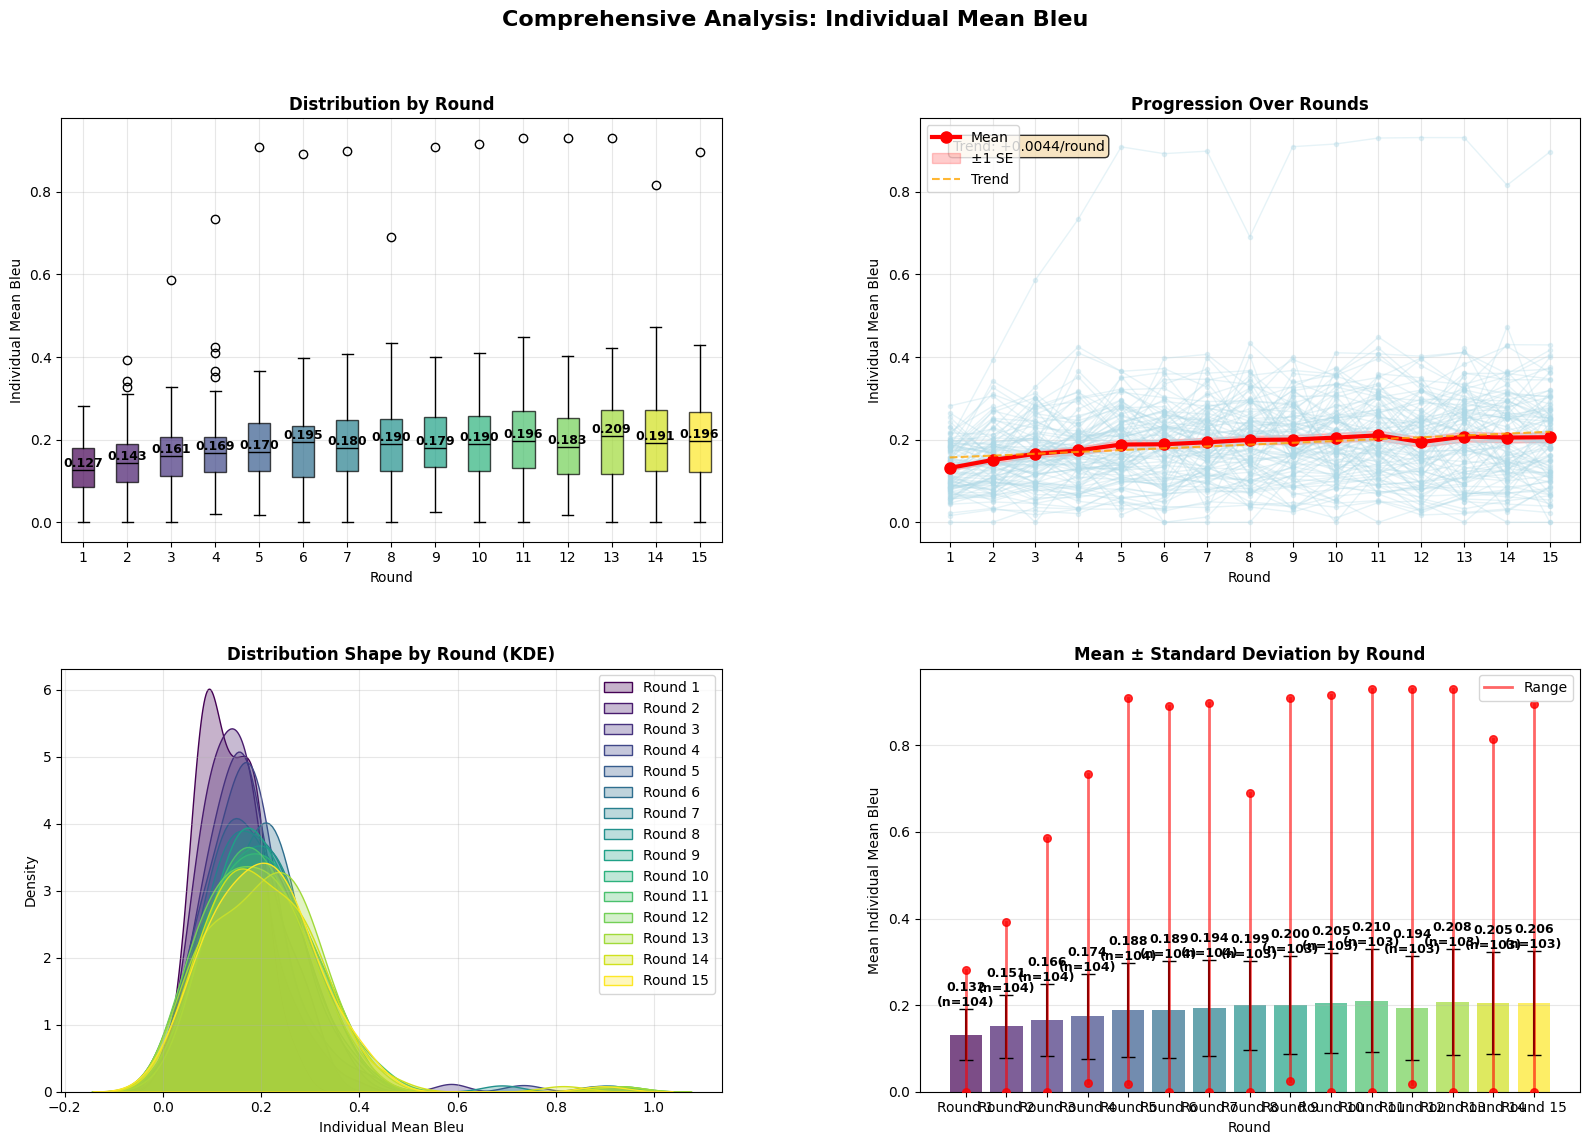

=== SUMMARY STATISTICS FOR INDIVIDUAL_MEAN_BLEU ===

Overall Statistics:
  Mean: 0.1879
  Std:  0.1083
  Min:  0.0000
  Max:  0.9310

By Round:
       count    mean     std     min     max
round                                       
1        104  0.1316  0.0587  0.0000  0.2816
2        104  0.1507  0.0728  0.0000  0.3919
3        104  0.1657  0.0835  0.0000  0.5870
4        104  0.1739  0.0977  0.0210  0.7339
5        104  0.1882  0.1086  0.0180  0.9085
6        104  0.1889  0.1120  0.0000  0.8920
7        104  0.1937  0.1110  0.0000  0.8981
8        103  0.1994  0.1037  0.0000  0.6906
9        103  0.2002  0.1122  0.0247  0.9089
10       103  0.2049  0.1159  0.0000  0.9154
11       103  0.2104  0.1186  0.0000  0.9299
12       103  0.1942  0.1199  0.0178  0.9310
13       103  0.2076  0.1228  0.0000  0.9309
14       103  0.2051  0.1169  0.0000  0.8157
15       103  0.2059  0.1199  0.0000  0.8965


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0192 (

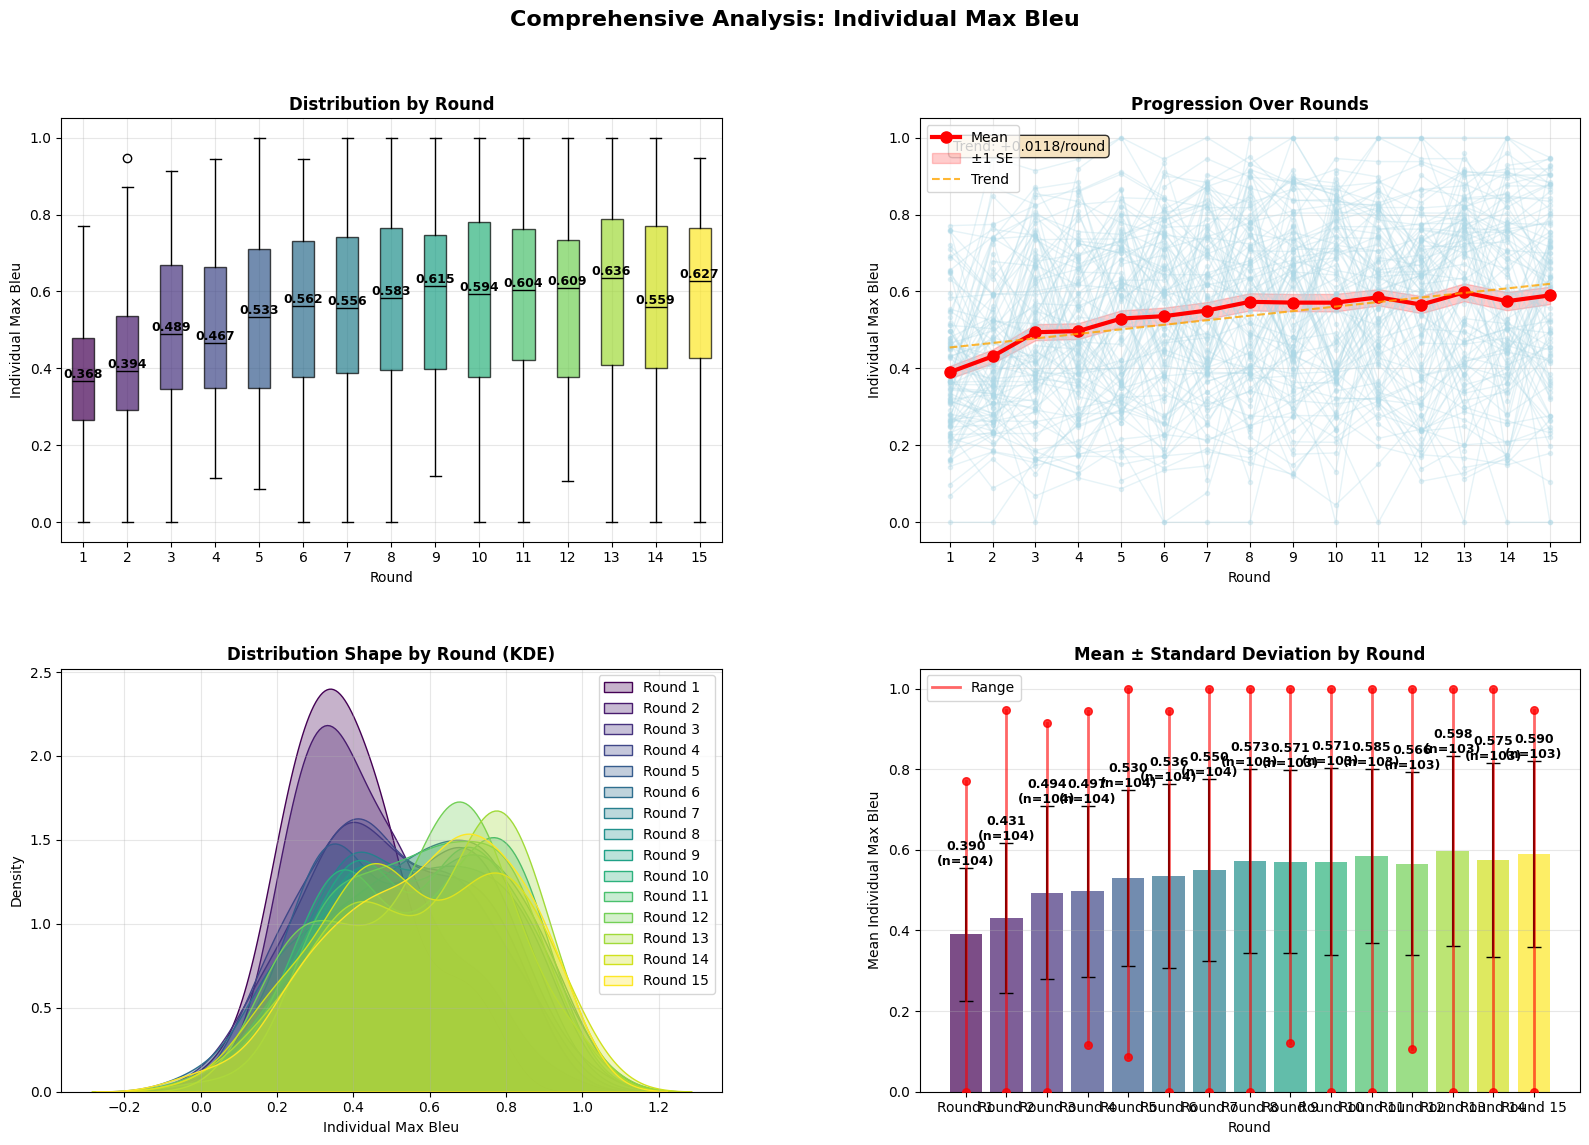

=== SUMMARY STATISTICS FOR INDIVIDUAL_MAX_BLEU ===

Overall Statistics:
  Mean: 0.5369
  Std:  0.2264
  Min:  0.0000
  Max:  1.0000

By Round:
       count    mean     std     min     max
round                                       
1        104  0.3901  0.1653  0.0000  0.7710
2        104  0.4313  0.1855  0.0000  0.9480
3        104  0.4941  0.2136  0.0000  0.9137
4        104  0.4970  0.2115  0.1155  0.9436
5        104  0.5296  0.2177  0.0873  1.0000
6        104  0.5358  0.2278  0.0000  0.9436
7        104  0.5504  0.2255  0.0000  1.0000
8        103  0.5731  0.2288  0.0000  1.0000
9        103  0.5710  0.2273  0.1208  1.0000
10       103  0.5709  0.2319  0.0000  1.0000
11       103  0.5849  0.2151  0.0000  1.0000
12       103  0.5658  0.2270  0.1067  1.0000
13       103  0.5977  0.2358  0.0000  1.0000
14       103  0.5748  0.2412  0.0000  1.0000
15       103  0.5899  0.2309  0.0000  0.9480


Statistical Tests (Welch's t-test between consecutive rounds):
  Round 1 → 2: Δ=+0.0412 (+

In [15]:
output_directory = "output/metric_analysis_first_run"

# 3. Run the analysis for a single metric
print("--- Running analysis for a single metric ---")
#create_comprehensive_metric_plots(df_metrics_sample, 'mean_combined_score', save_dir=output_directory)

# 4. Run the full analysis for all metrics
# Set interactive=False for an automated run that saves all files without stopping
print("\n\n--- Running analysis for ALL metrics (non-interactive) ---")
analyze_all_metrics_individually(df_metrics, save_dir=output_directory, interactive=False)

print(f"\n✅ All analyses complete. Results are saved in the '{output_directory}' folder.")